In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from PIL import Image
import os

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision import models

from tqdm import tqdm
import timm

from datetime import datetime

/home/hpclab01/jupyter_server_test/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's load the different bird species from the `class_names.npy` file and then the attributes from `attributes.npy` which has for every class 312 features that are explained by the file `attributes.txt`.

In [2]:
images_df = pd.read_csv("data/train_images.csv")
images_df["image_path"] = images_df["image_path"].apply(lambda x: os.path.join("data", x.lstrip("/")))
images_df.head()

,image_path,label
0,data/train_images/1.jpg,1
1,data/train_images/2.jpg,1
2,data/train_images/3.jpg,1
3,data/train_images/4.jpg,1
4,data/train_images/5.jpg,1


In [3]:
from torch.utils.data import WeightedRandomSampler

label_counts = images_df['label'].value_counts()
num_samples = len(images_df)

class_weights = {cls: num_samples / count for cls, count in label_counts.items()}
sample_weights = images_df['label'].map(class_weights).values

In [4]:
bird_classes = np.load("data/class_names.npy", allow_pickle=True).item()
attributes = np.load('data/attributes.npy')
attributes.shape

(200, 312)

In [5]:
with open("data/attributes.txt", "r") as f:
    attribute_names = [line.strip() for line in f.readlines()]
attribute_names[:5]

['1 has_bill_shape::curved_(up_or_down)',
 '2 has_bill_shape::dagger',
 '3 has_bill_shape::hooked',
 '4 has_bill_shape::needle',
 '5 has_bill_shape::hooked_seabird']

Unify the attributes files to map for every bird species they're features

Create a data frame `birds_df` with the class_id and the 312 attrbiutes of each bird class. Then merge it with the class name of each bird.

In [6]:
class_attributes = {}
for class_id in range(attributes.shape[0]):
    class_attributes[class_id + 1] = {
        attribute_names[i]: attributes[class_id, i] for i in range(len(attribute_names))
    }

birds_df = pd.DataFrame.from_dict(class_attributes, orient="index")
birds_df.index.name = "class_id"
birds_df.reset_index(inplace=True)
birds_df.head()

,class_id,1 has_bill_shape::curved_(up_or_down),2 has_bill_shape::dagger,3 has_bill_shape::hooked,4 has_bill_shape::needle,5 has_bill_shape::hooked_seabird,6 has_bill_shape::spatulate,7 has_bill_shape::all-purpose,8 has_bill_shape::cone,9 has_bill_shape::specialized,...,303 has_crown_color::pink,304 has_crown_color::orange,305 has_crown_color::black,306 has_crown_color::white,307 has_crown_color::red,308 has_crown_color::buff,309 has_wing_pattern::solid,310 has_wing_pattern::spotted,311 has_wing_pattern::striped,312 has_wing_pattern::multi-colored
0,1,0.010638,0.010638,0.007092,0.003546,0.138299,0.065603,0.000000,0.005319,0.000000,...,0.000000,0.005439,0.005439,0.228446,0.000000,0.000000,0.186020,0.009186,0.025262,0.020669
1,2,0.000000,0.011332,0.009444,0.000000,0.202095,0.041552,0.015110,0.005666,0.000000,...,0.006291,0.000000,0.111144,0.008388,0.000000,0.046135,0.202572,0.002665,0.021323,0.058639
2,3,0.000000,0.000000,0.007425,0.000000,0.002475,0.000000,0.000000,0.074247,0.146020,...,0.000000,0.000000,0.190411,0.012555,0.000000,0.010462,0.203609,0.000000,0.008853,0.017705
3,4,0.000000,0.000000,0.003861,0.000000,0.003861,0.013514,0.005792,0.073360,0.138998,...,0.004885,0.000000,0.190531,0.000000,0.000000,0.000000,0.152750,0.006840,0.036478,0.043317
4,5,0.000000,0.035088,0.000000,0.000000,0.000000,0.000000,0.102458,0.070177,0.000000,...,0.000000,0.000000,0.204036,0.002458,0.002458,0.000000,0.031640,0.002751,0.015132,0.158200


Create dataframe mapping bird names with their id

In [7]:
classes = pd.DataFrame.from_dict(bird_classes, orient="index").reset_index()
classes.columns = ["class", "id"]
classes.head()

,class,id
0,001.Black_footed_Albatross,1
1,002.Laysan_Albatross,2
2,003.Sooty_Albatross,3
3,004.Groove_billed_Ani,4
4,005.Crested_Auklet,5


Merge class name with the attributes

In [8]:
birds_df = birds_df.merge(classes, left_on="class_id", right_on="id")
birds_df = birds_df.drop(columns=["id"])

# Reorder columns to have class_id and class first
cols = ["class_id", "class"] + [c for c in birds_df.columns if c not in ["class_id", "class"]]
birds_df = birds_df[cols]
birds_df.head()

,class_id,class,1 has_bill_shape::curved_(up_or_down),2 has_bill_shape::dagger,3 has_bill_shape::hooked,4 has_bill_shape::needle,5 has_bill_shape::hooked_seabird,6 has_bill_shape::spatulate,7 has_bill_shape::all-purpose,8 has_bill_shape::cone,...,303 has_crown_color::pink,304 has_crown_color::orange,305 has_crown_color::black,306 has_crown_color::white,307 has_crown_color::red,308 has_crown_color::buff,309 has_wing_pattern::solid,310 has_wing_pattern::spotted,311 has_wing_pattern::striped,312 has_wing_pattern::multi-colored
0,1,001.Black_footed_Albatross,0.010638,0.010638,0.007092,0.003546,0.138299,0.065603,0.000000,0.005319,...,0.000000,0.005439,0.005439,0.228446,0.000000,0.000000,0.186020,0.009186,0.025262,0.020669
1,2,002.Laysan_Albatross,0.000000,0.011332,0.009444,0.000000,0.202095,0.041552,0.015110,0.005666,...,0.006291,0.000000,0.111144,0.008388,0.000000,0.046135,0.202572,0.002665,0.021323,0.058639
2,3,003.Sooty_Albatross,0.000000,0.000000,0.007425,0.000000,0.002475,0.000000,0.000000,0.074247,...,0.000000,0.000000,0.190411,0.012555,0.000000,0.010462,0.203609,0.000000,0.008853,0.017705
3,4,004.Groove_billed_Ani,0.000000,0.000000,0.003861,0.000000,0.003861,0.013514,0.005792,0.073360,...,0.004885,0.000000,0.190531,0.000000,0.000000,0.000000,0.152750,0.006840,0.036478,0.043317
4,5,005.Crested_Auklet,0.000000,0.035088,0.000000,0.000000,0.000000,0.000000,0.102458,0.070177,...,0.000000,0.000000,0.204036,0.002458,0.002458,0.000000,0.031640,0.002751,0.015132,0.158200


### Define Device (GPU or CPU)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Load training metadata and create train/validation split
We create a stratified train/validation split so that all 200 classes are represented proportionally in both sets.  
This split will be used to train the CNN on `train_images` and evaluate it on `val_images`.


In [10]:
train_images, val_images = train_test_split(
    images_df,
    test_size=0.2,
    stratify=images_df["label"],
    random_state=42
)
len(train_images), len(val_images)

(3140, 786)

In [11]:
train_images.head()

,image_path,label
1249,data/train_images/1250.jpg,42
3882,data/train_images/3883.jpg,193
686,data/train_images/687.jpg,23
1452,data/train_images/1453.jpg,49
2357,data/train_images/2358.jpg,85


### Create a custom PyTorch Dataset for bird images

Here we define a `BirdsDataset` class that:
- Reads the image path and label from the DataFrame rows.
- Loads each image with PIL.
- Applies the appropriate transform (train or validation).
- Converts labels from 1–200 to 0–199 so they work with `nn.CrossEntropyLoss`.

This Dataset will be used together with a DataLoader to efficiently feed batches to the CNN.

In [12]:
class BirdsDataset(Dataset):
    def __init__(self, df, transform=None, use_attributes=False, is_test=False):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.use_attributes = use_attributes
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)

        if self.is_test:
            return img
        else:
            label = int(row["label"]) - 1  # for training set also return the label in 0-199
            return img, label

### Wrap Datasets in DataLoaders

Now we create `DataLoader` objects for the training and validation sets.  
DataLoaders handle:
- Shuffling (for training),
- Batching,
- Parallel loading of images (with `num_workers`).

These will be used directly in the training and evaluation loops.


### Define Loaders

In [13]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Makes cuDNN deterministic (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [14]:
# to handle the imbalance in data
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True)

In [31]:
def define_loaders(train_images, val_images, device, batch_size, generator):

    train_dataset = BirdsDataset(train_images, transform=train_transform)
    val_dataset = BirdsDataset(val_images, transform=val_transform)
    
    if device == 'cpu': 
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            #sampler = sampler, # if use set shuffle = False
            shuffle=True,  # model sees data in random order
            generator=generator,
            num_workers=0, # parallel processing
            pin_memory=True # faster data transfer to GPU
        )
    
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True
        )
    else:
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,  # model sees data in random order
            num_workers=4, # parallel processing
            pin_memory=True # faster data transfer to GPU
        )
    
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )
    return train_loader, val_loader

### 🛑 EarlyStopping Callback

The `EarlyStopping` class is a training utility that monitors validation loss and stops training when the model stops improving.  
This helps prevent **overfitting** and saves training time.

#### 🔍 How it works
- **patience**: How many epochs to wait for improvement before stopping.
- **min_delta**: Minimum decrease in validation loss that counts as an improvement.
- **best_score**: Tracks the best (lowest) validation loss seen so far.
- **counter**: Counts how many consecutive epochs had no improvement.
- **early_stop**: Becomes `True` when early stopping should trigger.

#### 📉 When validation loss improves:
- The model’s weights are saved to `checkpoint.pt`.
- The counter resets to 0.

#### 📈 When validation loss does *not* improve:
- The counter increases.
- If the counter reaches `patience`, training will stop early.

This class is typically used during training loops to prevent unnecessary epochs once the model stops learning.

In [32]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self._update(val_loss)

        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self._update(val_loss)
            self.counter = 0

    def _update(self, val_loss):
        if self.verbose:
            print(
                f'Validation loss decreased '
                f'({self.val_loss_min:.6f} → {val_loss:.6f}).'
            )
        self.val_loss_min = val_loss

### To plot training vs accuracy per epoch

In [33]:
def train_val_plot(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Acc")
    plt.plot(epochs, val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### Initialize Test Dataset

In [34]:
def initialize_test_dataset(test_path, test_transform): 
    test_df = pd.read_csv(test_path)
    test_df["image_path"] = test_df["image_path"].apply(lambda x: os.path.join("data", x.lstrip("/")))
    
    test_dataset = BirdsDataset(test_df, transform=test_transform, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
    
    return test_loader

#### Initialize predictions and cnn_models folder

In [35]:
os.makedirs("predictions", exist_ok=True)
os.makedirs("cnn_models", exist_ok=True)

## Our current best CNN Architecture

## Approach: Replicate ResNet and use attributes

In [36]:
# Basic Residual Block used in ResNet-18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection if dimensions change
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

# ResNet-18 CNN architecture
class ResNet18CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_channels = 64

        # Initial convolution + BN + ReLU + MaxPool
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

    def _make_layer(self, out_channels, blocks, stride):
        layers = [BasicBlock(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x  # Output feature maps

In [37]:
class ResNet18AttrMultiTask(nn.Module):
    def __init__(self, class_attributes, feat_dim=512, scale=10.0):
        super().__init__()
        self.num_classes = class_attributes.shape[0]
        self.attr_dim = class_attributes.shape[1]
        self.scale = scale

        # CNN backbone
        self.cnn = ResNet18CNN()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Project CNN features to attribute space
        self.attr_proj = nn.Linear(feat_dim, self.attr_dim, bias=False)
        self.dropout = nn.Dropout(p=0.2)

        # Learnable class embeddings
        self.class_embeddings = nn.Parameter(class_attributes.clone())

    def forward(self, x):
        # 1️⃣ CNN feature extraction
        features = self.cnn(x)
        features = self.avgpool(features)
        features = torch.flatten(features, 1)  # (batch, feat_dim)
        features = self.dropout(features)

        # Project to attribute space
        attr_pred = self.attr_proj(features)  # (batch, attr_dim)

        # Cosine similarity classifier
        x_norm = F.normalize(attr_pred, p=2, dim=1)
        class_norm = F.normalize(self.class_embeddings, p=2, dim=1)
        logits = self.scale * torch.matmul(x_norm, class_norm.t())  # (batch, num_classes)

        return logits, attr_pred

1. Extracts deep features from the image using ResNet-18.

2. Projects features to attribute space (learned 312-dim vector).

3. Computes cosine similarity between image embedding and learnable class embeddings → predicts class.

4. Returns both class logits and predicted attributes, so you can do multi-task learning:

5. CrossEntropyLoss(logits, labels) → main supervised classification loss

6. MSELoss(attr_pred, true_attributes) → auxiliary attribute reconstruction loss

In [38]:
def multi_task_train_one_epoch(model, train_loader, optimizer, device, class_attributes, criterion_cls, criterion_attr, alpha):
    model.train()

    total_loss = 0
    total_correct = 0
    total_samples = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward
        logits, attr_pred = model(images)

        # Losses
        loss_cls = criterion_cls(logits, labels)
        true_attrs = class_attributes[labels].to(device)
        loss_attr = criterion_attr(attr_pred, true_attrs)

        loss = loss_cls + alpha * loss_attr
        loss.backward()
        optimizer.step()

        # Metrics
        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size
        total_correct += (logits.argmax(1) == labels).sum().item()
        total_samples += batch_size

    return (total_loss / total_samples, total_correct / total_samples)

In [39]:
def multi_task_evaluate(model, dataloader, device, class_attributes, criterion_cls, criterion_attr, alpha):
    model.eval()

    total_loss, total_correct, total_samples = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            logits, attr_pred = model(images)

            # Losses
            loss_cls = criterion_cls(logits, labels)
            true_attrs = class_attributes[labels].to(device)
            loss_attr = criterion_attr(attr_pred, true_attrs)

            loss = loss_cls + alpha * loss_attr

            # Metrics
            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size
            total_correct += (logits.argmax(1) == labels).sum().item()
            total_samples += batch_size

    return (total_loss / total_samples, total_correct / total_samples)

In [43]:
import random

In [47]:
def multi_task_train_model(model, model_path, class_attributes, optimizer, 
    alpha=0.01,
    scheduler=None,
    batch_size = 64,
    early_stopping_patience=10,
    num_epochs=300):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
    # same dataset for all the runs (and same shuffle)
    g = torch.Generator()
    g.manual_seed(42)
    set_seed(42)
    train_loader, val_loader = define_loaders(train_images, val_images, device, batch_size, generator=g)
    

    early_stopping = EarlyStopping(patience=early_stopping_patience, min_delta=0.0, verbose=True)

    model.to(device)

    num_params = sum(p.numel() for p in model.parameters())
    print('Total parameters:', num_params)
    
    # Prepare loss functions
    criterion_cls = nn.CrossEntropyLoss()
    criterion_attr = nn.MSELoss()

    best_val_acc = 0.0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        train_loss, train_acc = multi_task_train_one_epoch(model, train_loader, optimizer, device, class_attributes, criterion_cls, criterion_attr, alpha)

        val_loss, val_acc = multi_task_evaluate(model, val_loader, device, class_attributes, criterion_cls, criterion_attr, alpha)

        # Logging
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f" Train | loss: {train_loss:.4f}, acc: {train_acc:.4f}")
        print(f" Val   | loss: {val_loss:.4f}, acc: {val_acc:.4f}")

        # Scheduler step
        if scheduler:
            scheduler.step(val_loss)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(f"✔ Saved new best model (val_acc={best_val_acc:.4f})")

        # early stopping on val_loss
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    print('Best Validation accuracy:', best_val_acc)
    train_val_plot(train_losses, val_losses, train_accs, val_accs)
    
    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "best_val_acc": best_val_acc,
    }

In [48]:
# image transforms (too basic and overfits)

# train_transform = T.Compose([
#     T.Resize((224, 224)),
#     T.RandomHorizontalFlip(),
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225]),
# ])

# val_transform = T.Compose([
#     T.Resize((224, 224)),
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225]),
# ])

 # slightly aggressive transformation

train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)), 
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(15),  
    T.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1)
    ),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    T.RandomGrayscale(p=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.RandomErasing(p=0.2, scale=(0.02, 0.2))
])

val_transform = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# # transforms - INCREASE SIZE
# train_transform = T.Compose([
#     T.Resize((384,384)),
#     T.RandomResizedCrop(336, scale=(0.75, 1.0)),
#     T.RandomHorizontalFlip(p=0.5),
#     T.ColorJitter(0.3,0.3,0.3,0.05),
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     # optional RandomErasing but try without first
# ])

# val_transform = T.Compose([
#     T.Resize((384,384)),
#     T.CenterCrop(336),
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

In [49]:
class_attributes = torch.tensor(attributes, dtype=torch.float32).to(device) # (200, 312)
class_attributes = (class_attributes - class_attributes.mean(0)) / class_attributes.std(0)

# model = ResNet18AttrMultiTask(class_attributes).to(device)
scale=20
model = ResNet18AttrMultiTask(class_attributes, scale=scale).to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 1e-4
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # STRICTLY BETTER

batch_size = 64
alpha=0.1 # next try 0.2

# scheduler: reduce LR when val_loss plateaus
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# CAREFUL TO NOT OVERWRITE
model_name = "3.1cnn_replicate_resnet18.pt"
model_dir = "cnn_models"
model_path = os.path.join(model_dir, model_name)

In [50]:
results = multi_task_train_model(
    model=model,
    model_path=model_path,
    class_attributes=class_attributes,
    optimizer=optimizer,
    alpha=alpha,
    scheduler=scheduler,
    batch_size=batch_size)

Total parameters: 11398656

Epoch 1/300


100%|██████████| 50/50 [00:04<00:00, 11.50it/s]
/home/hpclab01/jupyter_server_test/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:204: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


 Train | loss: 5.7309, acc: 0.0070
 Val   | loss: 5.4221, acc: 0.0127
✔ Saved new best model (val_acc=0.0127)
Validation loss decreased (inf → 5.422127).

Epoch 2/300


100%|██████████| 50/50 [00:04<00:00, 12.20it/s]


 Train | loss: 5.4434, acc: 0.0159
 Val   | loss: 5.4033, acc: 0.0165
✔ Saved new best model (val_acc=0.0165)
Validation loss decreased (5.422127 → 5.403317).

Epoch 3/300


100%|██████████| 50/50 [00:04<00:00, 12.17it/s]


 Train | loss: 5.4052, acc: 0.0146
 Val   | loss: 5.2642, acc: 0.0229
✔ Saved new best model (val_acc=0.0229)
Validation loss decreased (5.403317 → 5.264183).

Epoch 4/300


100%|██████████| 50/50 [00:04<00:00, 12.03it/s]


 Train | loss: 5.3110, acc: 0.0220
 Val   | loss: 5.1916, acc: 0.0280
✔ Saved new best model (val_acc=0.0280)
Validation loss decreased (5.264183 → 5.191617).

Epoch 5/300


100%|██████████| 50/50 [00:04<00:00, 12.12it/s]


 Train | loss: 5.2257, acc: 0.0299
 Val   | loss: 5.2691, acc: 0.0369
✔ Saved new best model (val_acc=0.0369)
EarlyStopping counter: 1/10

Epoch 6/300


100%|██████████| 50/50 [00:04<00:00, 12.25it/s]


 Train | loss: 5.1785, acc: 0.0312
 Val   | loss: 5.1363, acc: 0.0458
✔ Saved new best model (val_acc=0.0458)
Validation loss decreased (5.191617 → 5.136304).

Epoch 7/300


100%|██████████| 50/50 [00:04<00:00, 11.86it/s]


 Train | loss: 5.1033, acc: 0.0404
 Val   | loss: 4.9729, acc: 0.0394
Validation loss decreased (5.136304 → 4.972941).

Epoch 8/300


100%|██████████| 50/50 [00:04<00:00, 12.28it/s]


 Train | loss: 5.0177, acc: 0.0478
 Val   | loss: 5.3143, acc: 0.0407
EarlyStopping counter: 1/10

Epoch 9/300


100%|██████████| 50/50 [00:04<00:00, 12.21it/s]


 Train | loss: 4.9799, acc: 0.0420
 Val   | loss: 5.1184, acc: 0.0433
EarlyStopping counter: 2/10

Epoch 10/300


100%|██████████| 50/50 [00:04<00:00, 11.91it/s]


 Train | loss: 4.8765, acc: 0.0535
 Val   | loss: 4.8573, acc: 0.0649
✔ Saved new best model (val_acc=0.0649)
Validation loss decreased (4.972941 → 4.857282).

Epoch 11/300


100%|██████████| 50/50 [00:04<00:00, 12.18it/s]


 Train | loss: 4.8636, acc: 0.0561
 Val   | loss: 4.8427, acc: 0.0687
✔ Saved new best model (val_acc=0.0687)
Validation loss decreased (4.857282 → 4.842653).

Epoch 12/300


100%|██████████| 50/50 [00:04<00:00, 11.92it/s]


 Train | loss: 4.7944, acc: 0.0557
 Val   | loss: 4.8006, acc: 0.0712
✔ Saved new best model (val_acc=0.0712)
Validation loss decreased (4.842653 → 4.800570).

Epoch 13/300


  8%|▊         | 4/50 [00:00<00:07,  5.82it/s]


KeyboardInterrupt: 

### Prediction

In [237]:
def multi_task_prediction(test_df, model, model_name, test_loader, test_path):
    all_preds = []

    model.eval()
    with torch.no_grad():
        for images in tqdm(test_loader):
            images = images.to(device)
            
            # Multi-task model returns (logits, attr_pred)
            logits, _ = model(images)  

            preds = torch.argmax(logits, 1)  # 0–199
            preds = preds.cpu().numpy() + 1  # 1–200 (CUB format)
            all_preds.extend(preds)
            
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    file_path = f"predictions/{model_name}_{timestamp}.csv"

    test_df["label"] = all_preds
    test_df[["id", "label"]].to_csv(file_path, index=False)

    print(f"Saved predictions to {file_path}")

In [238]:
# initialize model
model = ResNet18AttrMultiTask(class_attributes).to(device)  # , feat_dim=512, scale=10.0
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

test_dataset_path = "data/test_images_path.csv"
test_df = pd.read_csv(test_dataset_path)
test_loader = initialize_test_dataset(test_dataset_path, test_transform=val_transform)
multi_task_prediction(test_df, model, model_name, test_loader, test_dataset_path)

100%|██████████| 63/63 [00:02<00:00, 23.71it/s]

Saved predictions to predictions/3.1cnn_replicate_resnet18.pt_2025-12-12_03-15.csv


### Current best CNN model results

Best Validation accuracy: 0.3791348600508906


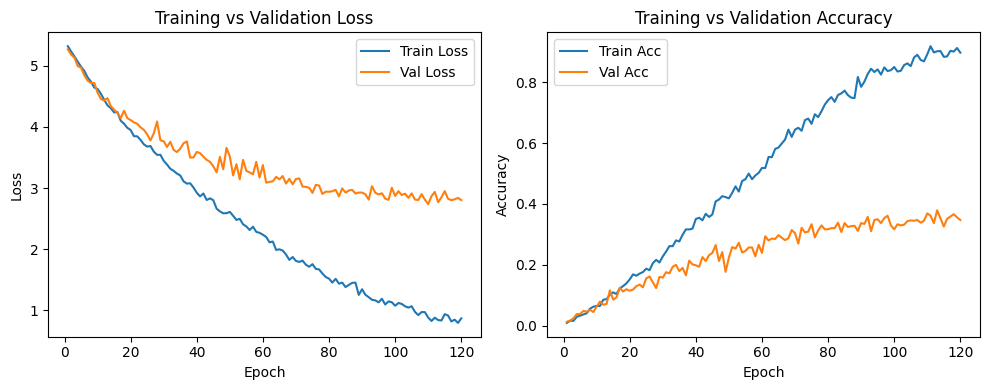

In [168]:
train_losses = results['train_losses']
val_losses = results['val_losses']
train_accs = results['train_accs']
val_accs = results['val_accs']
best_val_acc = results['best_val_acc']

print('Best Validation accuracy:', best_val_acc)
train_val_plot(train_losses, val_losses, train_accs, val_accs)

## END of Resnet 18 & Attributes Experimentation

## Other CNN Architectures we have tried

### Define training and validation loops

Here we implement two functions:

- `train_one_epoch`: runs one epoch over the training set, updates weights, and tracks loss and accuracy.
- `evaluate`: runs one full pass over the validation set without gradient updates, and reports loss and accuracy.

These utilities keep the main training loop clean and readable, and allow easy reuse later.

In [17]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Val", leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

### Define training model function

In [20]:
def train_model(model, model_path, batch_size, criterion, optimizer, early_stopping_patience=10, scheduler=None, num_epochs=300):    
     
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader = define_loaders(train_images, val_images, device, batch_size)

    early_stopping = EarlyStopping(patience=early_stopping_patience, min_delta=0.0, verbose=True)
    
    train_losses, val_losses, train_accs, val_accs = [], [], [], []    
    best_val_acc = 0.0

    num_params = sum(p.numel() for p in model.parameters())
    print('Total parameters:', num_params)
    
    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")
    
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if scheduler:
            scheduler.step(val_loss)
    
        print(f"  Train | loss: {train_loss:.4f}, acc: {train_acc:.4f}")
        print(f"  Val   | loss: {val_loss:.4f}, acc: {val_acc:.4f}")
    
        # save best model by val acc
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(f"New best model saved with val_acc = {best_val_acc:.4f}")
    
        # early stopping on val_loss
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
            
    train_val_plot(train_losses, val_losses, train_accs, val_accs)

### Define prediction using CNN model

In [23]:
def prediction(test_df, model, model_name, test_loader, test_path):
    all_preds = []
    
    with torch.no_grad():
        for images in tqdm(test_loader):
            images = images.to(device)
    
            logits = model(images)          # (B, 200)
            preds = torch.argmax(logits, 1) # 0–199
    
            preds = preds.cpu().numpy() + 1 # 1–200 (CUB format)
            all_preds.extend(preds)
            
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    file_path = f"predictions/{model_name}_{timestamp}.csv"
    
    test_df["label"] = all_preds
    test_df[["id", "label"]].to_csv(file_path, index=False)
    
    print(f"Saved predictions to {file_path}")

## SimpleCNN Architecture Overview

This `SimpleCNN` model is a custom convolutional neural network designed for fine-grained classification of **200 bird species**.  
It consists of four convolutional blocks that progressively extract deeper visual features, followed by global average pooling and two fully-connected layers for classification.

---

### 🔍 **Architecture Breakdown**

#### **1. Convolutional Feature Extractor (4 Blocks)**  
Each conv block contains:
- A **3×3 convolution**
- **Batch Normalization** (stabilizes training)
- **ReLU activation**
- **2×2 Max Pooling** (halves spatial resolution)

Feature map progression:

| Block | Input Channels | Output Channels | Resolution Change |
|-------|----------------|------------------|-------------------|
| Conv1 | 3 → 32         | 224×224 → 112×112 |
| Conv2 | 32 → 64        | 112×112 → 56×56  |
| Conv3 | 64 → 128       | 56×56 → 28×28    |
| Conv4 | 128 → 256      | 28×28 → 14×14    |

This deepening structure allows the model to learn:
- low-level edges and textures (block 1–2)  
- mid-level shapes and patterns (block 3)  
- high-level semantic features (block 4)

---

### **2. Adaptive Average Pooling**
The 14×14 output of the last conv block is reduced to **4×4** using:

```python
nn.AdaptiveAvgPool2d((4, 4))


In [24]:
class SimpleCNN(nn.Module):
    def __init__(self, attr_dim=312):
        super(SimpleCNN, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)    # 224 → 112
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)    # 112 → 56
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)    # 56 → 28
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)    # 28 → 14
        )

        self.gap = nn.AdaptiveAvgPool2d((4, 4))  # 14 → 4

        self.fc_img = nn.Linear(256 * 4 * 4, attr_dim)
        # self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc_img(x))   # (B, 312)
        # x = self.dropout(x)
        return x

### 1st approach: Cosine Classifier Head

In [108]:
class CosineClassifier(nn.Module):
    def __init__(self, attributes):
        super().__init__()

        # attributes: (num_classes, attr_dim)
        init_attrs = F.normalize(attributes, dim=1)

        # Make them learnable
        self.class_attrs = nn.Parameter(init_attrs)

        # Learnable scale parameter
        self.scale = nn.Parameter(torch.tensor(10.0))

    def forward(self, feats):
        # Normalize features AND class attributes during forward
        feats = F.normalize(feats, dim=1)
        class_attrs = F.normalize(self.class_attrs, dim=1)

        logits = self.scale * feats @ class_attrs.t()
        return logits


#### Combine the feature vector of CNN with the Cosine head to predict

In [109]:
class CNNWithCosineHead(nn.Module):
    def __init__(self, attributes):
        super().__init__()
        self.backbone = SimpleCNN(attr_dim=attributes.shape[1])
        self.head = CosineClassifier(attributes)

    def forward(self, x):
        feats = self.backbone(x)   # (B, 312)
        logits = self.head(feats)  # (B, 200)
        return logits

#### Train the CNN baseline model and monitor accuracy

We run the training for a few epochs.  
For each epoch, we log:
- Training loss and accuracy
- Validation loss and accuracy

We also keep track of the best validation accuracy and save the model weights whenever a new best score is reached.  


In [58]:
attributes = torch.tensor(attributes, dtype=torch.float32)  # (200, 312)
model = CNNWithCosineHead(attributes=attributes).to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
batch_size = 64

# scheduler: reduce LR when val_loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# CAREFUL TO NOT OVERWRITE
model_name = "3cnn_cosine_similarity.pt"
model_dir = "cnn_models"
model_path = os.path.join(model_dir, model_name)

/tmp/ipykernel_2033974/2765742098.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attributes = torch.tensor(attributes, dtype=torch.float32)  # (200, 312)


Total parameters: 1730041

Epoch 1/300


  Train | loss: 5.2756, acc: 0.0089
  Val   | loss: 5.1325, acc: 0.0178
New best model saved with val_acc = 0.0178
Validation loss decreased (inf → 5.132510).

Epoch 2/300


  Train | loss: 5.0810, acc: 0.0150
  Val   | loss: 4.9579, acc: 0.0216
New best model saved with val_acc = 0.0216
Validation loss decreased (5.132510 → 4.957935).

Epoch 3/300


  Train | loss: 4.9087, acc: 0.0283
  Val   | loss: 4.9866, acc: 0.0229
New best model saved with val_acc = 0.0229
EarlyStopping counter: 1/10

Epoch 4/300


  Train | loss: 4.7243, acc: 0.0468
  Val   | loss: 4.7084, acc: 0.0585
New best model saved with val_acc = 0.0585
Validation loss decreased (4.957935 → 4.708441).

Epoch 5/300


  Train | loss: 4.5226, acc: 0.0627
  Val   | loss: 4.5308, acc: 0.0585
Validation loss decreased (4.708441 → 4.530793).

Epoch 6/300


  Train | loss: 4.3189, acc: 0.0850
  Val   | loss: 4.4251, acc: 0.0738
New best model saved with val_acc = 0.0738
Validation loss decreased (4.530793 → 4.425137).

Epoch 7/300


  Train | loss: 4.1599, acc: 0.0965
  Val   | loss: 4.3167, acc: 0.0891
New best model saved with val_acc = 0.0891
Validation loss decreased (4.425137 → 4.316732).

Epoch 8/300


  Train | loss: 3.9875, acc: 0.1207
  Val   | loss: 4.2465, acc: 0.0827
Validation loss decreased (4.316732 → 4.246475).

Epoch 9/300


  Train | loss: 3.8178, acc: 0.1500
  Val   | loss: 4.1396, acc: 0.1120
New best model saved with val_acc = 0.1120
Validation loss decreased (4.246475 → 4.139552).

Epoch 10/300


  Train | loss: 3.6915, acc: 0.1589
  Val   | loss: 4.1382, acc: 0.1209
New best model saved with val_acc = 0.1209
Validation loss decreased (4.139552 → 4.138167).

Epoch 11/300


  Train | loss: 3.5531, acc: 0.1876
  Val   | loss: 4.0037, acc: 0.1196
Validation loss decreased (4.138167 → 4.003733).

Epoch 12/300


  Train | loss: 3.3993, acc: 0.2185
  Val   | loss: 3.9455, acc: 0.1196
Validation loss decreased (4.003733 → 3.945462).

Epoch 13/300


  Train | loss: 3.2830, acc: 0.2424
  Val   | loss: 3.9248, acc: 0.1285
New best model saved with val_acc = 0.1285
Validation loss decreased (3.945462 → 3.924832).

Epoch 14/300


  Train | loss: 3.1666, acc: 0.2570
  Val   | loss: 3.8934, acc: 0.1336
New best model saved with val_acc = 0.1336
Validation loss decreased (3.924832 → 3.893352).

Epoch 15/300


  Train | loss: 3.0253, acc: 0.2815
  Val   | loss: 3.8341, acc: 0.1489
New best model saved with val_acc = 0.1489
Validation loss decreased (3.893352 → 3.834119).

Epoch 16/300


  Train | loss: 3.0012, acc: 0.2952
  Val   | loss: 3.7905, acc: 0.1387
Validation loss decreased (3.834119 → 3.790545).

Epoch 17/300


  Train | loss: 2.8244, acc: 0.3280
  Val   | loss: 3.7859, acc: 0.1425
Validation loss decreased (3.790545 → 3.785882).

Epoch 18/300


  Train | loss: 2.6909, acc: 0.3646
  Val   | loss: 3.7263, acc: 0.1578
New best model saved with val_acc = 0.1578
Validation loss decreased (3.785882 → 3.726301).

Epoch 19/300


  Train | loss: 2.5791, acc: 0.3920
  Val   | loss: 3.7095, acc: 0.1730
New best model saved with val_acc = 0.1730
Validation loss decreased (3.726301 → 3.709520).

Epoch 20/300


  Train | loss: 2.5259, acc: 0.4131
  Val   | loss: 3.6847, acc: 0.1718
Validation loss decreased (3.709520 → 3.684720).

Epoch 21/300


  Train | loss: 2.4010, acc: 0.4379
  Val   | loss: 3.6741, acc: 0.1692
Validation loss decreased (3.684720 → 3.674136).

Epoch 22/300


  Train | loss: 2.3329, acc: 0.4573
  Val   | loss: 3.6268, acc: 0.1743
New best model saved with val_acc = 0.1743
Validation loss decreased (3.674136 → 3.626816).

Epoch 23/300


  Train | loss: 2.2555, acc: 0.4707
  Val   | loss: 3.6065, acc: 0.1718
Validation loss decreased (3.626816 → 3.606549).

Epoch 24/300


  Train | loss: 2.1249, acc: 0.5204
  Val   | loss: 3.6315, acc: 0.1781
New best model saved with val_acc = 0.1781
EarlyStopping counter: 1/10

Epoch 25/300


  Train | loss: 2.0932, acc: 0.5115
  Val   | loss: 3.6783, acc: 0.1730
EarlyStopping counter: 2/10

Epoch 26/300


  Train | loss: 2.0500, acc: 0.5264
  Val   | loss: 3.5902, acc: 0.1959
New best model saved with val_acc = 0.1959
Validation loss decreased (3.606549 → 3.590197).

Epoch 27/300


  Train | loss: 1.9138, acc: 0.5815
  Val   | loss: 3.6436, acc: 0.1832
EarlyStopping counter: 1/10

Epoch 28/300


  Train | loss: 1.8600, acc: 0.5936
  Val   | loss: 3.5669, acc: 0.1934
Validation loss decreased (3.590197 → 3.566947).

Epoch 29/300


  Train | loss: 1.8166, acc: 0.6073
  Val   | loss: 3.6389, acc: 0.1883
EarlyStopping counter: 1/10

Epoch 30/300


  Train | loss: 1.6993, acc: 0.6366
  Val   | loss: 3.6022, acc: 0.2087
New best model saved with val_acc = 0.2087
EarlyStopping counter: 2/10

Epoch 31/300


  Train | loss: 1.5815, acc: 0.6720
  Val   | loss: 3.6122, acc: 0.2036
EarlyStopping counter: 3/10

Epoch 32/300


  Train | loss: 1.5534, acc: 0.6847
  Val   | loss: 3.5867, acc: 0.2048
EarlyStopping counter: 4/10

Epoch 33/300


  Train | loss: 1.5451, acc: 0.6796
  Val   | loss: 3.6022, acc: 0.2150
New best model saved with val_acc = 0.2150
EarlyStopping counter: 5/10

Epoch 34/300


  Train | loss: 1.4908, acc: 0.6987
  Val   | loss: 3.6776, acc: 0.1985
EarlyStopping counter: 6/10

Epoch 35/300


  Train | loss: 1.4378, acc: 0.7169
  Val   | loss: 3.6190, acc: 0.2137
EarlyStopping counter: 7/10

Epoch 36/300


  Train | loss: 1.3292, acc: 0.7516
  Val   | loss: 3.6192, acc: 0.2074
EarlyStopping counter: 8/10

Epoch 37/300


  Train | loss: 1.3141, acc: 0.7459
  Val   | loss: 3.6222, acc: 0.2163
New best model saved with val_acc = 0.2163
EarlyStopping counter: 9/10

Epoch 38/300


  Train | loss: 1.2126, acc: 0.7869
  Val   | loss: 3.6590, acc: 0.2087
EarlyStopping counter: 10/10
Early stopping triggered.


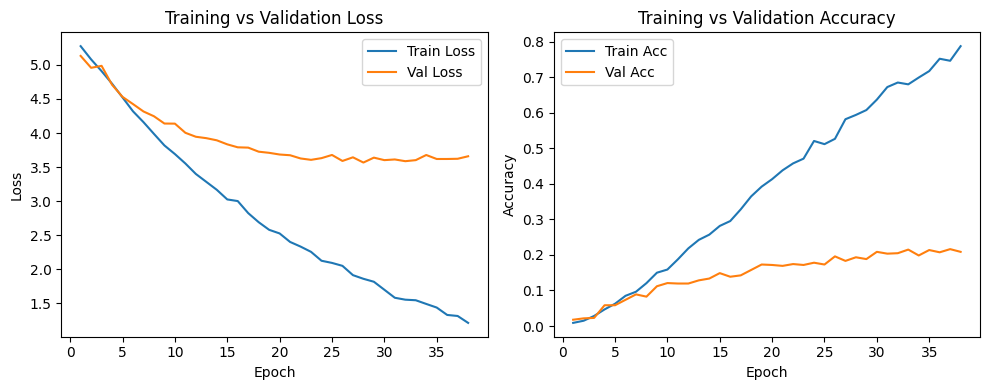

In [59]:
train_model(model=model, model_path=model_path, batch_size=batch_size, criterion=criterion, optimizer=optimizer) 

#### Prediction

In [61]:
# initialize model
attributes = torch.tensor(attributes, dtype=torch.float32)  # (200, 312)
model = CNNWithCosineHead(attributes).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

/tmp/ipykernel_2033974/3264626634.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attributes = torch.tensor(attributes, dtype=torch.float32)  # (200, 312)


CNNWithCosineHead(
  (backbone): SimpleCNN(
    (conv_block1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block4): Sequentia

In [62]:
test_dataset_path = "data/test_images_path.csv"
test_df = pd.read_csv(test_dataset_path)
test_loader = initialize_test_dataset(test_dataset_path, test_transform=val_transform)
prediction(test_df, model, model_name, test_loader, test_dataset_path)

100%|██████████| 63/63 [00:02<00:00, 25.20it/s]

Saved predictions to predictions/3cnn_cosine_similarity.pt_2025-12-11_21-14.csv


## 2nd Approach:
replicating "Comprehensive Analysis of Deep Learning Methodology in Classification of Leukocytes and Enhancement Using Swish Activation Units"

In [74]:
# --- Swish Activation ---
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


# --- Paper CNN Backbone adapted for 224×224 ---
class PaperCNNBackbone(nn.Module):
    def __init__(self, feat_dim=512):
        super().__init__()

        self.act = Swish()

        # -------- Block 1 -------- (paper: Conv → BN → Swish → MaxPool)
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            Swish(),
            nn.MaxPool2d(2)          # 224 → 112
        )

        # -------- Block 2 --------
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            Swish(),
            nn.MaxPool2d(2),         # 112 → 56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            Swish(),
            nn.MaxPool2d(2)          # 56 → 28
        )

        # paper uses flatten, not GAP — we keep that
        # 224→112→56→28 = spatial size 28×28
        self.flatten_dim = 128 * 28 * 28

        # -------- FC head (paper: FC 512 + BN + Swish) --------
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_dim, feat_dim),
            nn.BatchNorm1d(feat_dim),
            Swish()
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [75]:
class CosineClassifier(nn.Module):
    def __init__(self, num_classes, feat_dim, scale=10.0):
        super(CosineClassifier, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.scale = scale

        # one weight vector per class
        self.weight = nn.Parameter(torch.randn(num_classes, feat_dim))
        nn.init.xavier_normal_(self.weight)  

    def forward(self, feats):
        # feats: (B, feat_dim)
        feats_n = F.normalize(feats, dim=1)          # (B, D)
        weight_n = F.normalize(self.weight, dim=1)   # (C, D)

        # cosine similarity: (B, D) @ (D, C) = (B, C)
        logits = self.scale * feats_n @ weight_n.t()
        return logits

In [76]:
class CNNWithCosineHead(nn.Module):
    def __init__(self, num_classes=200, feat_dim=512, scale=10.0):
        super().__init__()
        self.backbone = PaperCNNBackbone(feat_dim=feat_dim)
        self.head = CosineClassifier(num_classes=num_classes, feat_dim=feat_dim, scale=scale)
    def forward(self, x):
        feats = self.backbone(x)
        logits = self.head(feats)
        return logits

In [81]:
model = CNNWithCosineHead(num_classes=200, feat_dim=512, scale=10.0).to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
batch_size = 64

# scheduler: reduce LR when val_loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# CAREFUL TO NOT OVERWRITE
model_name = "3cnn_replicate_paper_cosine_similarity.pt"
model_dir = "cnn_models"
model_path = os.path.join(model_dir, model_name)

Total parameters: 51577856

Epoch 1/300


  Train | loss: 5.2830, acc: 0.0166
  Val   | loss: 5.0090, acc: 0.0305
New best model saved with val_acc = 0.0305
Validation loss decreased (inf → 5.008992).

Epoch 2/300


  Train | loss: 4.9697, acc: 0.0341
  Val   | loss: 4.8368, acc: 0.0445
New best model saved with val_acc = 0.0445
Validation loss decreased (5.008992 → 4.836761).

Epoch 3/300


  Train | loss: 4.8036, acc: 0.0478
  Val   | loss: 4.6966, acc: 0.0585
New best model saved with val_acc = 0.0585
Validation loss decreased (4.836761 → 4.696645).

Epoch 4/300


  Train | loss: 4.6744, acc: 0.0618
  Val   | loss: 4.5697, acc: 0.0929
New best model saved with val_acc = 0.0929
Validation loss decreased (4.696645 → 4.569696).

Epoch 5/300


  Train | loss: 4.5636, acc: 0.0790
  Val   | loss: 4.5106, acc: 0.0865
Validation loss decreased (4.569696 → 4.510562).

Epoch 6/300


  Train | loss: 4.4611, acc: 0.0869
  Val   | loss: 4.4409, acc: 0.0891
Validation loss decreased (4.510562 → 4.440941).

Epoch 7/300


  Train | loss: 4.3723, acc: 0.0955
  Val   | loss: 4.3544, acc: 0.0941
New best model saved with val_acc = 0.0941
Validation loss decreased (4.440941 → 4.354377).

Epoch 8/300


  Train | loss: 4.2834, acc: 0.1067
  Val   | loss: 4.3265, acc: 0.1158
New best model saved with val_acc = 0.1158
Validation loss decreased (4.354377 → 4.326473).

Epoch 9/300


  Train | loss: 4.2042, acc: 0.1309
  Val   | loss: 4.2979, acc: 0.0980
Validation loss decreased (4.326473 → 4.297875).

Epoch 10/300


  Train | loss: 4.1682, acc: 0.1239
  Val   | loss: 4.3217, acc: 0.1043
EarlyStopping counter: 1/10

Epoch 11/300


  Train | loss: 4.1179, acc: 0.1354
  Val   | loss: 4.2008, acc: 0.1272
New best model saved with val_acc = 0.1272
Validation loss decreased (4.297875 → 4.200848).

Epoch 12/300


  Train | loss: 4.1119, acc: 0.1306
  Val   | loss: 4.2006, acc: 0.1234
Validation loss decreased (4.200848 → 4.200649).

Epoch 13/300


  Train | loss: 4.0120, acc: 0.1424
  Val   | loss: 4.1491, acc: 0.1196
Validation loss decreased (4.200649 → 4.149075).

Epoch 14/300


  Train | loss: 3.9443, acc: 0.1656
  Val   | loss: 4.1271, acc: 0.1310
New best model saved with val_acc = 0.1310
Validation loss decreased (4.149075 → 4.127073).

Epoch 15/300


  Train | loss: 3.8884, acc: 0.1682
  Val   | loss: 4.0938, acc: 0.1247
Validation loss decreased (4.127073 → 4.093781).

Epoch 16/300


  Train | loss: 3.8296, acc: 0.1672
  Val   | loss: 4.0799, acc: 0.1361
New best model saved with val_acc = 0.1361
Validation loss decreased (4.093781 → 4.079934).

Epoch 17/300


  Train | loss: 3.8164, acc: 0.1841
  Val   | loss: 4.0608, acc: 0.1285
Validation loss decreased (4.079934 → 4.060762).

Epoch 18/300


  Train | loss: 3.7708, acc: 0.1879
  Val   | loss: 4.0303, acc: 0.1349
Validation loss decreased (4.060762 → 4.030259).

Epoch 19/300


  Train | loss: 3.7386, acc: 0.1943
  Val   | loss: 3.9985, acc: 0.1489
New best model saved with val_acc = 0.1489
Validation loss decreased (4.030259 → 3.998534).

Epoch 20/300


  Train | loss: 3.6781, acc: 0.2013
  Val   | loss: 3.9817, acc: 0.1438
Validation loss decreased (3.998534 → 3.981675).

Epoch 21/300


  Train | loss: 3.6335, acc: 0.2108
  Val   | loss: 3.9929, acc: 0.1387
EarlyStopping counter: 1/10

Epoch 22/300


  Train | loss: 3.6433, acc: 0.2150
  Val   | loss: 4.0436, acc: 0.1476
EarlyStopping counter: 2/10

Epoch 23/300


  Train | loss: 3.5676, acc: 0.2248
  Val   | loss: 3.9410, acc: 0.1489
Validation loss decreased (3.981675 → 3.940979).

Epoch 24/300


  Train | loss: 3.5806, acc: 0.2210
  Val   | loss: 3.8831, acc: 0.1552
New best model saved with val_acc = 0.1552
Validation loss decreased (3.940979 → 3.883129).

Epoch 25/300


  Train | loss: 3.5149, acc: 0.2315
  Val   | loss: 3.9797, acc: 0.1514
EarlyStopping counter: 1/10

Epoch 26/300


  Train | loss: 3.4731, acc: 0.2481
  Val   | loss: 3.8932, acc: 0.1654
New best model saved with val_acc = 0.1654
EarlyStopping counter: 2/10

Epoch 27/300


  Train | loss: 3.4772, acc: 0.2471
  Val   | loss: 3.8508, acc: 0.1781
New best model saved with val_acc = 0.1781
Validation loss decreased (3.883129 → 3.850808).

Epoch 28/300


  Train | loss: 3.5253, acc: 0.2389
  Val   | loss: 3.8742, acc: 0.1654
EarlyStopping counter: 1/10

Epoch 29/300


  Train | loss: 3.4466, acc: 0.2506
  Val   | loss: 3.8589, acc: 0.1743
EarlyStopping counter: 2/10

Epoch 30/300


  Train | loss: 3.4102, acc: 0.2475
  Val   | loss: 3.8031, acc: 0.1654
Validation loss decreased (3.850808 → 3.803104).

Epoch 31/300


  Train | loss: 3.3824, acc: 0.2659
  Val   | loss: 3.8787, acc: 0.1603
EarlyStopping counter: 1/10

Epoch 32/300


  Train | loss: 3.3720, acc: 0.2561
  Val   | loss: 3.7736, acc: 0.1705
Validation loss decreased (3.803104 → 3.773570).

Epoch 33/300


  Train | loss: 3.3092, acc: 0.2723
  Val   | loss: 3.8075, acc: 0.1641
EarlyStopping counter: 1/10

Epoch 34/300


  Train | loss: 3.2996, acc: 0.2780
  Val   | loss: 3.8213, acc: 0.1654
EarlyStopping counter: 2/10

Epoch 35/300


  Train | loss: 3.2637, acc: 0.2764
  Val   | loss: 3.8028, acc: 0.1692
EarlyStopping counter: 3/10

Epoch 36/300


  Train | loss: 3.2375, acc: 0.3025
  Val   | loss: 3.8141, acc: 0.1628
EarlyStopping counter: 4/10

Epoch 37/300


  Train | loss: 3.1483, acc: 0.3204
  Val   | loss: 3.7219, acc: 0.1781
Validation loss decreased (3.773570 → 3.721930).

Epoch 38/300


  Train | loss: 3.1369, acc: 0.3264
  Val   | loss: 3.7313, acc: 0.1768
EarlyStopping counter: 1/10

Epoch 39/300


  Train | loss: 3.1151, acc: 0.3306
  Val   | loss: 3.7078, acc: 0.1845
New best model saved with val_acc = 0.1845
Validation loss decreased (3.721930 → 3.707779).

Epoch 40/300


  Train | loss: 3.0976, acc: 0.3354
  Val   | loss: 3.7225, acc: 0.1870
New best model saved with val_acc = 0.1870
EarlyStopping counter: 1/10

Epoch 41/300


  Train | loss: 3.1107, acc: 0.3325
  Val   | loss: 3.7093, acc: 0.1870
EarlyStopping counter: 2/10

Epoch 42/300


  Train | loss: 3.0500, acc: 0.3382
  Val   | loss: 3.7251, acc: 0.1807
EarlyStopping counter: 3/10

Epoch 43/300


  Train | loss: 3.0488, acc: 0.3459
  Val   | loss: 3.6824, acc: 0.1845
Validation loss decreased (3.707779 → 3.682409).

Epoch 44/300


  Train | loss: 3.1059, acc: 0.3277
  Val   | loss: 3.6766, acc: 0.1985
New best model saved with val_acc = 0.1985
Validation loss decreased (3.682409 → 3.676581).

Epoch 45/300


  Train | loss: 3.0765, acc: 0.3414
  Val   | loss: 3.6842, acc: 0.1921
EarlyStopping counter: 1/10

Epoch 46/300


  Train | loss: 3.0831, acc: 0.3354
  Val   | loss: 3.6865, acc: 0.1908
EarlyStopping counter: 2/10

Epoch 47/300


  Train | loss: 3.0603, acc: 0.3369
  Val   | loss: 3.6743, acc: 0.2023
New best model saved with val_acc = 0.2023
Validation loss decreased (3.676581 → 3.674267).

Epoch 48/300


  Train | loss: 3.0534, acc: 0.3430
  Val   | loss: 3.6852, acc: 0.1908
EarlyStopping counter: 1/10

Epoch 49/300


  Train | loss: 3.0662, acc: 0.3401
  Val   | loss: 3.6765, acc: 0.2010
EarlyStopping counter: 2/10

Epoch 50/300


  Train | loss: 3.0445, acc: 0.3430
  Val   | loss: 3.6690, acc: 0.1934
Validation loss decreased (3.674267 → 3.668987).

Epoch 51/300


  Train | loss: 3.0482, acc: 0.3449
  Val   | loss: 3.6773, acc: 0.1883
EarlyStopping counter: 1/10

Epoch 52/300


  Train | loss: 3.0423, acc: 0.3506
  Val   | loss: 3.6838, acc: 0.1959
EarlyStopping counter: 2/10

Epoch 53/300


  Train | loss: 3.0643, acc: 0.3449
  Val   | loss: 3.6904, acc: 0.1908
EarlyStopping counter: 3/10

Epoch 54/300


  Train | loss: 3.0190, acc: 0.3621
  Val   | loss: 3.6484, acc: 0.2010
Validation loss decreased (3.668987 → 3.648415).

Epoch 55/300


  Train | loss: 3.0119, acc: 0.3592
  Val   | loss: 3.6666, acc: 0.1908
EarlyStopping counter: 1/10

Epoch 56/300


  Train | loss: 3.0332, acc: 0.3471
  Val   | loss: 3.6649, acc: 0.2010
EarlyStopping counter: 2/10

Epoch 57/300


  Train | loss: 3.0185, acc: 0.3567
  Val   | loss: 3.6462, acc: 0.2048
New best model saved with val_acc = 0.2048
Validation loss decreased (3.648415 → 3.646232).

Epoch 58/300


  Train | loss: 3.0152, acc: 0.3583
  Val   | loss: 3.6354, acc: 0.1985
Validation loss decreased (3.646232 → 3.635446).

Epoch 59/300


  Train | loss: 3.0192, acc: 0.3583
  Val   | loss: 3.6368, acc: 0.2061
New best model saved with val_acc = 0.2061
EarlyStopping counter: 1/10

Epoch 60/300


  Train | loss: 3.0010, acc: 0.3643
  Val   | loss: 3.6675, acc: 0.1985
EarlyStopping counter: 2/10

Epoch 61/300


  Train | loss: 2.9857, acc: 0.3659
  Val   | loss: 3.6537, acc: 0.2023
EarlyStopping counter: 3/10

Epoch 62/300


  Train | loss: 3.0155, acc: 0.3640
  Val   | loss: 3.6380, acc: 0.2087
New best model saved with val_acc = 0.2087
EarlyStopping counter: 4/10

Epoch 63/300


  Train | loss: 2.9790, acc: 0.3541
  Val   | loss: 3.6430, acc: 0.1985
EarlyStopping counter: 5/10

Epoch 64/300


  Train | loss: 2.9690, acc: 0.3643
  Val   | loss: 3.6420, acc: 0.1972
EarlyStopping counter: 6/10

Epoch 65/300


  Train | loss: 2.9572, acc: 0.3831
  Val   | loss: 3.6485, acc: 0.1921
EarlyStopping counter: 7/10

Epoch 66/300


  Train | loss: 2.9674, acc: 0.3726
  Val   | loss: 3.6409, acc: 0.1972
EarlyStopping counter: 8/10

Epoch 67/300


  Train | loss: 2.9718, acc: 0.3720
  Val   | loss: 3.6272, acc: 0.2010
Validation loss decreased (3.635446 → 3.627245).

Epoch 68/300


  Train | loss: 2.9785, acc: 0.3599
  Val   | loss: 3.6539, acc: 0.1972
EarlyStopping counter: 1/10

Epoch 69/300


  Train | loss: 2.9560, acc: 0.3793
  Val   | loss: 3.6422, acc: 0.1985
EarlyStopping counter: 2/10

Epoch 70/300


  Train | loss: 2.9654, acc: 0.3726
  Val   | loss: 3.6282, acc: 0.1985
EarlyStopping counter: 3/10

Epoch 71/300


  Train | loss: 2.9854, acc: 0.3605
  Val   | loss: 3.6509, acc: 0.2023
EarlyStopping counter: 4/10

Epoch 72/300


  Train | loss: 2.9659, acc: 0.3748
  Val   | loss: 3.6337, acc: 0.2061
EarlyStopping counter: 5/10

Epoch 73/300


  Train | loss: 2.9685, acc: 0.3787
  Val   | loss: 3.6361, acc: 0.1985
EarlyStopping counter: 6/10

Epoch 74/300


  Train | loss: 2.9632, acc: 0.3774
  Val   | loss: 3.6484, acc: 0.1947
EarlyStopping counter: 7/10

Epoch 75/300


  Train | loss: 2.9519, acc: 0.3780
  Val   | loss: 3.6301, acc: 0.2036
EarlyStopping counter: 8/10

Epoch 76/300


  Train | loss: 2.9648, acc: 0.3573
  Val   | loss: 3.6381, acc: 0.2036
EarlyStopping counter: 9/10

Epoch 77/300


  Train | loss: 2.9556, acc: 0.3761
  Val   | loss: 3.6234, acc: 0.2074
Validation loss decreased (3.627245 → 3.623446).

Epoch 78/300


  Train | loss: 2.9856, acc: 0.3561
  Val   | loss: 3.6557, acc: 0.1921
EarlyStopping counter: 1/10

Epoch 79/300


  Train | loss: 2.9594, acc: 0.3732
  Val   | loss: 3.6370, acc: 0.1997
EarlyStopping counter: 2/10

Epoch 80/300


  Train | loss: 2.9513, acc: 0.3768
  Val   | loss: 3.6435, acc: 0.2048
EarlyStopping counter: 3/10

Epoch 81/300


  Train | loss: 2.9570, acc: 0.3755
  Val   | loss: 3.6416, acc: 0.1997
EarlyStopping counter: 4/10

Epoch 82/300


  Train | loss: 2.9679, acc: 0.3678
  Val   | loss: 3.6421, acc: 0.1997
EarlyStopping counter: 5/10

Epoch 83/300


  Train | loss: 2.9540, acc: 0.3694
  Val   | loss: 3.6443, acc: 0.1985
EarlyStopping counter: 6/10

Epoch 84/300


  Train | loss: 2.9645, acc: 0.3656
  Val   | loss: 3.6613, acc: 0.1959
EarlyStopping counter: 7/10

Epoch 85/300


  Train | loss: 2.9701, acc: 0.3624
  Val   | loss: 3.6570, acc: 0.1934
EarlyStopping counter: 8/10

Epoch 86/300


  Train | loss: 2.9677, acc: 0.3745
  Val   | loss: 3.6351, acc: 0.1972
EarlyStopping counter: 9/10

Epoch 87/300


  Train | loss: 2.9622, acc: 0.3732
  Val   | loss: 3.6466, acc: 0.2036
EarlyStopping counter: 10/10
Early stopping triggered.


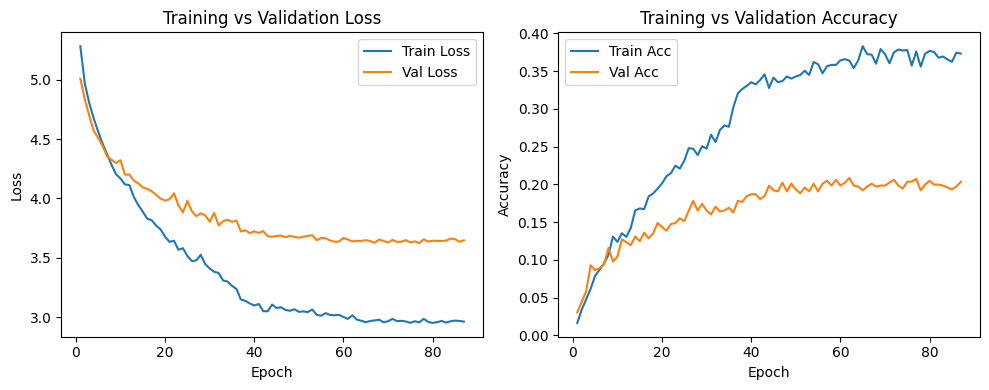

In [82]:
train_model(model=model, model_path=model_path, batch_size=batch_size, criterion=criterion, optimizer=optimizer, scheduler=scheduler) 

### Prediction

In [85]:
# initialize model
model = CNNWithCosineHead(num_classes=200, feat_dim=512, scale=10.0).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

test_dataset_path = "data/test_images_path.csv"
test_df = pd.read_csv(test_dataset_path)
test_loader = initialize_test_dataset(test_dataset_path, test_transform=val_transform)
prediction(test_df, model, model_name, test_loader, test_dataset_path)

100%|██████████| 63/63 [00:02<00:00, 24.28it/s]

Saved predictions to predictions/3cnn_replicate_paper_cosine_similarity.pt_2025-12-11_21-31.csv


### 3rd Approach: Replicating ResNet-18 structure

In [111]:
# Basic Residual Block used in ResNet-18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection if dimensions change
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

# ResNet-18 CNN architecture
class ResNet18CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_channels = 64

        # Initial convolution + BN + ReLU + MaxPool
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

    def _make_layer(self, out_channels, blocks, stride):
        layers = [BasicBlock(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x  # Output feature maps

In [ ]:
# DOES NOT USE COSINE
class ResNet18ForCUB200(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.cnn = ResNet18CNN()  # the CNN feature extractor
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)  # 512 = output channels of ResNet-18

    def forward(self, x):
        x = self.cnn(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [112]:
model = ResNet18ForCUB200().to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
batch_size = 64

# scheduler: reduce LR when val_loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# CAREFUL TO NOT OVERWRITE
model_name = "3cnn_replicate_resnet18.pt"
model_dir = "cnn_models"
model_path = os.path.join(model_dir, model_name)

Total parameters: 11279112

Epoch 1/300


  Train | loss: 5.3368, acc: 0.0140
  Val   | loss: 7.4435, acc: 0.0089
New best model saved with val_acc = 0.0089
Validation loss decreased (inf → 7.443513).

Epoch 2/300


  Train | loss: 5.2579, acc: 0.0111
  Val   | loss: 6.2244, acc: 0.0127
New best model saved with val_acc = 0.0127
Validation loss decreased (7.443513 → 6.224367).

Epoch 3/300


  Train | loss: 5.1429, acc: 0.0115
  Val   | loss: 4.9546, acc: 0.0165
New best model saved with val_acc = 0.0165
Validation loss decreased (6.224367 → 4.954612).

Epoch 4/300


  Train | loss: 5.0036, acc: 0.0197
  Val   | loss: 4.8930, acc: 0.0242
New best model saved with val_acc = 0.0242
Validation loss decreased (4.954612 → 4.893014).

Epoch 5/300


  Train | loss: 4.9559, acc: 0.0232
  Val   | loss: 4.8519, acc: 0.0394
New best model saved with val_acc = 0.0394
Validation loss decreased (4.893014 → 4.851861).

Epoch 6/300


  Train | loss: 4.8966, acc: 0.0226
  Val   | loss: 4.8175, acc: 0.0369
Validation loss decreased (4.851861 → 4.817515).

Epoch 7/300


  Train | loss: 4.8195, acc: 0.0277
  Val   | loss: 4.8221, acc: 0.0356
EarlyStopping counter: 1/10

Epoch 8/300


  Train | loss: 4.7709, acc: 0.0347
  Val   | loss: 4.7950, acc: 0.0369
Validation loss decreased (4.817515 → 4.794979).

Epoch 9/300


  Train | loss: 4.7187, acc: 0.0395
  Val   | loss: 4.6188, acc: 0.0623
New best model saved with val_acc = 0.0623
Validation loss decreased (4.794979 → 4.618802).

Epoch 10/300


  Train | loss: 4.6261, acc: 0.0411
  Val   | loss: 4.8280, acc: 0.0445
EarlyStopping counter: 1/10

Epoch 11/300


  Train | loss: 4.5700, acc: 0.0475
  Val   | loss: 4.6635, acc: 0.0649
New best model saved with val_acc = 0.0649
EarlyStopping counter: 2/10

Epoch 12/300


  Train | loss: 4.5582, acc: 0.0471
  Val   | loss: 4.6121, acc: 0.0534
Validation loss decreased (4.618802 → 4.612079).

Epoch 13/300


  Train | loss: 4.4419, acc: 0.0596
  Val   | loss: 4.5673, acc: 0.0611
Validation loss decreased (4.612079 → 4.567312).

Epoch 14/300


  Train | loss: 4.3928, acc: 0.0583
  Val   | loss: 4.4964, acc: 0.0700
New best model saved with val_acc = 0.0700
Validation loss decreased (4.567312 → 4.496377).

Epoch 15/300


  Train | loss: 4.3390, acc: 0.0717
  Val   | loss: 4.5708, acc: 0.0674
EarlyStopping counter: 1/10

Epoch 16/300


  Train | loss: 4.2642, acc: 0.0790
  Val   | loss: 4.5818, acc: 0.0649
EarlyStopping counter: 2/10

Epoch 17/300


  Train | loss: 4.2143, acc: 0.0806
  Val   | loss: 4.6950, acc: 0.0560
EarlyStopping counter: 3/10

Epoch 18/300


  Train | loss: 4.2113, acc: 0.0850
  Val   | loss: 4.1935, acc: 0.0814
New best model saved with val_acc = 0.0814
Validation loss decreased (4.496377 → 4.193515).

Epoch 19/300


  Train | loss: 4.0980, acc: 0.0962
  Val   | loss: 4.4364, acc: 0.0700
EarlyStopping counter: 1/10

Epoch 20/300


  Train | loss: 4.0272, acc: 0.1013
  Val   | loss: 4.5156, acc: 0.0916
New best model saved with val_acc = 0.0916
EarlyStopping counter: 2/10

Epoch 21/300


  Train | loss: 4.0335, acc: 0.1073
  Val   | loss: 4.1689, acc: 0.0929
New best model saved with val_acc = 0.0929
Validation loss decreased (4.193515 → 4.168938).

Epoch 22/300


  Train | loss: 3.9125, acc: 0.1134
  Val   | loss: 4.0629, acc: 0.1107
New best model saved with val_acc = 0.1107
Validation loss decreased (4.168938 → 4.062875).

Epoch 23/300


  Train | loss: 3.8572, acc: 0.1197
  Val   | loss: 4.2144, acc: 0.1170
New best model saved with val_acc = 0.1170
EarlyStopping counter: 1/10

Epoch 24/300


  Train | loss: 3.8049, acc: 0.1334
  Val   | loss: 3.9804, acc: 0.1310
New best model saved with val_acc = 0.1310
Validation loss decreased (4.062875 → 3.980368).

Epoch 25/300


  Train | loss: 3.7079, acc: 0.1341
  Val   | loss: 4.3726, acc: 0.1132
EarlyStopping counter: 1/10

Epoch 26/300


  Train | loss: 3.6205, acc: 0.1592
  Val   | loss: 4.0346, acc: 0.1285
EarlyStopping counter: 2/10

Epoch 27/300


  Train | loss: 3.5671, acc: 0.1726
  Val   | loss: 4.0254, acc: 0.1145
EarlyStopping counter: 3/10

Epoch 28/300


  Train | loss: 3.5036, acc: 0.1717
  Val   | loss: 4.1835, acc: 0.1132
EarlyStopping counter: 4/10

Epoch 29/300


  Train | loss: 3.1633, acc: 0.2379
  Val   | loss: 3.5466, acc: 0.1896
New best model saved with val_acc = 0.1896
Validation loss decreased (3.980368 → 3.546577).

Epoch 30/300


  Train | loss: 3.0168, acc: 0.2685
  Val   | loss: 3.5341, acc: 0.1870
Validation loss decreased (3.546577 → 3.534140).

Epoch 31/300


  Train | loss: 2.9613, acc: 0.2787
  Val   | loss: 3.4391, acc: 0.1985
New best model saved with val_acc = 0.1985
Validation loss decreased (3.534140 → 3.439055).

Epoch 32/300


  Train | loss: 2.9397, acc: 0.2831
  Val   | loss: 3.4423, acc: 0.1997
New best model saved with val_acc = 0.1997
EarlyStopping counter: 1/10

Epoch 33/300


  Train | loss: 2.9008, acc: 0.2968
  Val   | loss: 3.4838, acc: 0.2036
New best model saved with val_acc = 0.2036
EarlyStopping counter: 2/10

Epoch 34/300


  Train | loss: 2.8684, acc: 0.2994
  Val   | loss: 3.4560, acc: 0.2023
EarlyStopping counter: 3/10

Epoch 35/300


  Train | loss: 2.8433, acc: 0.2994
  Val   | loss: 3.4543, acc: 0.2074
New best model saved with val_acc = 0.2074
EarlyStopping counter: 4/10

Epoch 36/300


  Train | loss: 2.8131, acc: 0.3140
  Val   | loss: 3.4576, acc: 0.2087
New best model saved with val_acc = 0.2087
EarlyStopping counter: 5/10

Epoch 37/300


  Train | loss: 2.7854, acc: 0.3223
  Val   | loss: 3.4178, acc: 0.2087
Validation loss decreased (3.439055 → 3.417833).

Epoch 38/300


  Train | loss: 2.7612, acc: 0.3194
  Val   | loss: 3.4633, acc: 0.2099
New best model saved with val_acc = 0.2099
EarlyStopping counter: 1/10

Epoch 39/300


  Train | loss: 2.7732, acc: 0.3280
  Val   | loss: 3.4168, acc: 0.2087
Validation loss decreased (3.417833 → 3.416839).

Epoch 40/300


  Train | loss: 2.7929, acc: 0.3134
  Val   | loss: 3.4136, acc: 0.2112
New best model saved with val_acc = 0.2112
Validation loss decreased (3.416839 → 3.413579).

Epoch 41/300


  Train | loss: 2.7601, acc: 0.3274
  Val   | loss: 3.4118, acc: 0.2163
New best model saved with val_acc = 0.2163
Validation loss decreased (3.413579 → 3.411832).

Epoch 42/300


  Train | loss: 2.7871, acc: 0.3188
  Val   | loss: 3.3832, acc: 0.2226
New best model saved with val_acc = 0.2226
Validation loss decreased (3.411832 → 3.383192).

Epoch 43/300


  Train | loss: 2.8121, acc: 0.3156
  Val   | loss: 3.4047, acc: 0.2087
EarlyStopping counter: 1/10

Epoch 44/300


  Train | loss: 2.7616, acc: 0.3232
  Val   | loss: 3.4104, acc: 0.2176
EarlyStopping counter: 2/10

Epoch 45/300


  Train | loss: 2.7745, acc: 0.3213
  Val   | loss: 3.3918, acc: 0.2137
EarlyStopping counter: 3/10

Epoch 46/300


  Train | loss: 2.7497, acc: 0.3229
  Val   | loss: 3.3787, acc: 0.2176
Validation loss decreased (3.383192 → 3.378740).

Epoch 47/300


  Train | loss: 2.7495, acc: 0.3325
  Val   | loss: 3.3911, acc: 0.2150
EarlyStopping counter: 1/10

Epoch 48/300


  Train | loss: 2.7568, acc: 0.3303
  Val   | loss: 3.3902, acc: 0.2176
EarlyStopping counter: 2/10

Epoch 49/300


  Train | loss: 2.7526, acc: 0.3252
  Val   | loss: 3.3836, acc: 0.2137
EarlyStopping counter: 3/10

Epoch 50/300


  Train | loss: 2.7505, acc: 0.3248
  Val   | loss: 3.3976, acc: 0.2176
EarlyStopping counter: 4/10

Epoch 51/300


  Train | loss: 2.7165, acc: 0.3271
  Val   | loss: 3.3947, acc: 0.2176
EarlyStopping counter: 5/10

Epoch 52/300


  Train | loss: 2.7216, acc: 0.3293
  Val   | loss: 3.3902, acc: 0.2150
EarlyStopping counter: 6/10

Epoch 53/300


  Train | loss: 2.7626, acc: 0.3299
  Val   | loss: 3.3848, acc: 0.2137
EarlyStopping counter: 7/10

Epoch 54/300


  Train | loss: 2.7471, acc: 0.3252
  Val   | loss: 3.3954, acc: 0.2137
EarlyStopping counter: 8/10

Epoch 55/300


  Train | loss: 2.7564, acc: 0.3248
  Val   | loss: 3.3781, acc: 0.2201
Validation loss decreased (3.378740 → 3.378122).

Epoch 56/300


  Train | loss: 2.7382, acc: 0.3252
  Val   | loss: 3.3886, acc: 0.2150
EarlyStopping counter: 1/10

Epoch 57/300


  Train | loss: 2.7330, acc: 0.3277
  Val   | loss: 3.3880, acc: 0.2125
EarlyStopping counter: 2/10

Epoch 58/300


  Train | loss: 2.7622, acc: 0.3350
  Val   | loss: 3.4258, acc: 0.2048
EarlyStopping counter: 3/10

Epoch 59/300


  Train | loss: 2.7597, acc: 0.3255
  Val   | loss: 3.3826, acc: 0.2125
EarlyStopping counter: 4/10

Epoch 60/300


  Train | loss: 2.7258, acc: 0.3357
  Val   | loss: 3.3926, acc: 0.2137
EarlyStopping counter: 5/10

Epoch 61/300


  Train | loss: 2.7433, acc: 0.3303
  Val   | loss: 3.3840, acc: 0.2125
EarlyStopping counter: 6/10

Epoch 62/300


  Train | loss: 2.7336, acc: 0.3303
  Val   | loss: 3.3858, acc: 0.2188
EarlyStopping counter: 7/10

Epoch 63/300


  Train | loss: 2.7452, acc: 0.3261
  Val   | loss: 3.3795, acc: 0.2137
EarlyStopping counter: 8/10

Epoch 64/300


  Train | loss: 2.7322, acc: 0.3462
  Val   | loss: 3.3800, acc: 0.2150
EarlyStopping counter: 9/10

Epoch 65/300


  Train | loss: 2.7581, acc: 0.3194
  Val   | loss: 3.4025, acc: 0.2023
EarlyStopping counter: 10/10
Early stopping triggered.


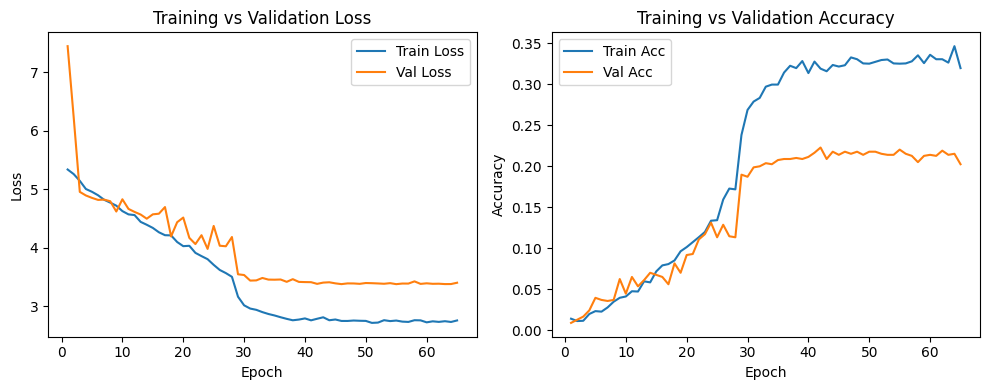

In [113]:
train_model(model=model, model_path=model_path, batch_size=batch_size, criterion=criterion, optimizer=optimizer, scheduler=scheduler) 

### Prediction

In [114]:
# initialize model
model = ResNet18ForCUB200().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

ResNet18ForCUB200(
  (cnn): ResNet18CNN(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, e

In [115]:
test_dataset_path = "data/test_images_path.csv"
test_df = pd.read_csv(test_dataset_path)
test_loader = initialize_test_dataset(test_dataset_path, test_transform=val_transform)
prediction(test_df, model, model_name, test_loader, test_dataset_path)

100%|██████████| 63/63 [00:02<00:00, 24.33it/s]

Saved predictions to predictions/3cnn_replicate_resnet18.pt_2025-12-12_00-17.csv


# END OF CUSTOM CNN ARCHITECTURE

# BASELINE MODELS

### Define a baseline pretrained model (ResNet18)

As a strong baseline, we use a pretrained `ResNet18` from `torchvision.models`:
- We load ImageNet-pretrained weights.
- We replace the final fully-connected layer so it outputs 200 logits (one per bird class).
- The rest of the network acts as a feature extractor.

This gives a solid starting point for accuracy without heavy custom architecture work.


In [20]:
# Load pretrained ResNet18
weights = models.ResNet18_Weights.IMAGENET1K_V1
ResNet_model = models.resnet18(weights=weights)

# Replace the final layer to match 200 classes
num_features = ResNet_model.fc.in_features
ResNet_model.fc = nn.Linear(num_features, 200)

ResNet_model = ResNet_model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
ResNet_optimizer = torch.optim.Adam(ResNet_model.parameters(), lr=1e-4)

In [25]:
baseline_model_name = "best_resnet18.pt"

In [22]:
baseline_model_dir = "cnn_models"
baseline_model_path = os.path.join(baseline_model_dir, model_name)
baseline_model_name = "best_resnet18.pt"

early_stopping = EarlyStopping(patience=5, min_delta=0.001, verbose=True)
num_epochs = 60
best_val_acc = 0.0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}") 

    train_loss, train_acc = train_one_epoch(
        ResNet_model, train_loader, ResNet_optimizer, criterion, device
    )

    # ---- validation ----
    val_loss, val_acc = evaluate(
        ResNet_model, val_loader, criterion, device
    )

    # ---- logging ----
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)


    # ---- early stopping ----
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

    print(f"  Train | loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"  Val   | loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    # ---- best model saving ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(ResNet_model.state_dict(), baseline_model_path)
        print(f"New best model saved with val_acc = {best_val_acc:.4f}")


Epoch 1/60


Validation loss decreased (inf → 3.807913).
  Train | loss: 4.1897, acc: 0.2032
  Val   | loss: 3.8079, acc: 0.2430
New best model saved with val_acc = 0.2430

Epoch 2/60


Validation loss decreased (3.807913 → 3.187853).
  Train | loss: 3.6171, acc: 0.3159
  Val   | loss: 3.1879, acc: 0.3575
New best model saved with val_acc = 0.3575

Epoch 3/60


Validation loss decreased (3.187853 → 2.964142).
  Train | loss: 3.1425, acc: 0.4137
  Val   | loss: 2.9641, acc: 0.4020
New best model saved with val_acc = 0.4020

Epoch 4/60


Validation loss decreased (2.964142 → 2.640698).
  Train | loss: 2.8124, acc: 0.4838
  Val   | loss: 2.6407, acc: 0.4402
New best model saved with val_acc = 0.4402

Epoch 5/60


Validation loss decreased (2.640698 → 2.436266).
  Train | loss: 2.5086, acc: 0.5382
  Val   | loss: 2.4363, acc: 0.4707
New best model saved with val_acc = 0.4707

Epoch 6/60


Validation loss decreased (2.436266 → 2.350031).
  Train | loss: 2.2327, acc: 0.5917
  Val   | loss: 2.3500, acc: 0.4873
New best model saved with val_acc = 0.4873

Epoch 7/60


Validation loss decreased (2.350031 → 2.149688).
  Train | loss: 1.9883, acc: 0.6462
  Val   | loss: 2.1497, acc: 0.5115
New best model saved with val_acc = 0.5115

Epoch 8/60


Validation loss decreased (2.149688 → 2.050521).
  Train | loss: 1.8013, acc: 0.6834
  Val   | loss: 2.0505, acc: 0.5191
New best model saved with val_acc = 0.5191

Epoch 9/60


Validation loss decreased (2.050521 → 1.963981).
  Train | loss: 1.6092, acc: 0.7236
  Val   | loss: 1.9640, acc: 0.5433
New best model saved with val_acc = 0.5433

Epoch 10/60


Validation loss decreased (1.963981 → 1.897009).
  Train | loss: 1.4451, acc: 0.7570
  Val   | loss: 1.8970, acc: 0.5585
New best model saved with val_acc = 0.5585

Epoch 11/60


Validation loss decreased (1.897009 → 1.818784).
  Train | loss: 1.3161, acc: 0.7939
  Val   | loss: 1.8188, acc: 0.5649
New best model saved with val_acc = 0.5649

Epoch 12/60


EarlyStopping counter: 1/5
  Train | loss: 1.1864, acc: 0.8150
  Val   | loss: 1.8262, acc: 0.5471

Epoch 13/60


Validation loss decreased (1.818784 → 1.773153).
  Train | loss: 1.0537, acc: 0.8385
  Val   | loss: 1.7732, acc: 0.5751
New best model saved with val_acc = 0.5751

Epoch 14/60


Validation loss decreased (1.773153 → 1.682336).
  Train | loss: 0.9602, acc: 0.8637
  Val   | loss: 1.6823, acc: 0.5789
New best model saved with val_acc = 0.5789

Epoch 15/60


EarlyStopping counter: 1/5
  Train | loss: 0.8622, acc: 0.8860
  Val   | loss: 1.6838, acc: 0.5738

Epoch 16/60


Validation loss decreased (1.682336 → 1.607470).
  Train | loss: 0.7598, acc: 0.9048
  Val   | loss: 1.6075, acc: 0.5852
New best model saved with val_acc = 0.5852

Epoch 17/60


EarlyStopping counter: 1/5
  Train | loss: 0.6886, acc: 0.9080
  Val   | loss: 1.6854, acc: 0.5738

Epoch 18/60


EarlyStopping counter: 2/5
  Train | loss: 0.6210, acc: 0.9280
  Val   | loss: 1.6346, acc: 0.5802

Epoch 19/60


EarlyStopping counter: 3/5
  Train | loss: 0.5649, acc: 0.9389
  Val   | loss: 1.6139, acc: 0.5992
New best model saved with val_acc = 0.5992

Epoch 20/60


Validation loss decreased (1.607470 → 1.586283).
  Train | loss: 0.5217, acc: 0.9449
  Val   | loss: 1.5863, acc: 0.6158
New best model saved with val_acc = 0.6158

Epoch 21/60


EarlyStopping counter: 1/5
  Train | loss: 0.4760, acc: 0.9446
  Val   | loss: 1.5992, acc: 0.6056

Epoch 22/60


EarlyStopping counter: 2/5
  Train | loss: 0.4300, acc: 0.9570
  Val   | loss: 1.5979, acc: 0.6031

Epoch 23/60


EarlyStopping counter: 3/5
  Train | loss: 0.4026, acc: 0.9554
  Val   | loss: 1.6106, acc: 0.5992

Epoch 24/60


EarlyStopping counter: 4/5
  Train | loss: 0.3993, acc: 0.9592
  Val   | loss: 1.5990, acc: 0.6005

Epoch 25/60


EarlyStopping counter: 5/5
Early stopping triggered!


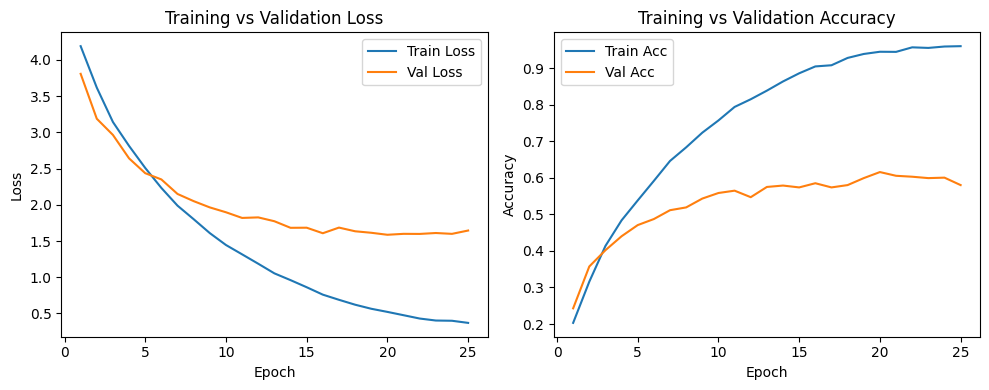

In [23]:
train_val_plot(train_losses, val_losses, train_accs, val_accs)

### Predict labels

In [24]:
ResNet_model = models.resnet18()
num_features = ResNet_model.fc.in_features
ResNet_model.fc = nn.Linear(num_features, 200)
ResNet_model.load_state_dict(torch.load("baseline_models/best_resnet18.pt", map_location=device))
ResNet_model = ResNet_model.to(device)
ResNet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
test_dataset_path = "data/test_images_path.csv"
test_df = pd.read_csv(test_dataset_path)
test_loader = initialize_test_dataset(test_dataset_path, test_transform=val_transform)
prediction(test_df, ResNet_model, baseline_model_name, test_loader, test_dataset_path)

100%|██████████| 63/63 [00:02<00:00, 21.45it/s]

Saved predictions to predictions/best_resnet18.pt_2025-12-11_20-12.csv


### Define a baseline CNN model (ResNet50) 

[https://huggingface.co/microsoft/resnet-50]

As a strong baseline, we use a pretrained `ResNet50` from `hugging face`:
- We load ImageNet-pretrained weights.
- We replace the final fully-connected layer so it outputs 200 logits (one per bird class).
- The rest of the network acts as a feature extractor.

This gives a solid starting point for accuracy without heavy custom architecture work.


### Try ResNet 50

In [21]:
# Load timm ResNet50 pretrained on ImageNet-1K
ResNet_model = timm.create_model("resnet50.a1_in1k", pretrained=True)

# Replace classifier for 200 classes
num_features = ResNet_model.get_classifier().in_features
ResNet_model.fc = nn.Linear(num_features, 200)
ResNet_model = ResNet_model.to(device)

criterion = nn.CrossEntropyLoss()

In [22]:
# Freeze everything
for param in ResNet_model.parameters():
    param.requires_grad = False

# Unfreeze last layer for the first epochs
for param in ResNet_model.fc.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, ResNet_model.parameters()), lr=1e-4, weight_decay=1e-4)

# optimizer = torch.optim.Adam(ResNet_model.parameters(), lr=1e-4)

### Train the ResNet50 baseline model and monitor accuracy

In [23]:
early_stopping = EarlyStopping(patience=5, min_delta=0.001, verbose=True)
num_epochs = 60
best_val_acc = 0.0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    
    # Unfreeze network after 3 epochs
    if epoch == 4:
        print("Unfreezing entire ResNet50")
        for param in ResNet_model.parameters():
            param.requires_grad = True

        # When you unfreeze, RECREATE optimizer to include all params
        optimizer = torch.optim.AdamW(
            ResNet_model.parameters(),
            lr=1e-4,          # OR something smaller: 5e-5
            weight_decay=1e-4
        )
        
    train_loss, train_acc = train_one_epoch(
        ResNet_model, train_loader, optimizer, criterion, device
    )

    # ---- validation ----
    val_loss, val_acc = evaluate(
        ResNet_model, val_loader, criterion, device
    )

    # ---- logging ----
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)


    # ---- early stopping ----
    early_stopping(val_loss, ResNet_model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

    print(f"  Train | loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"  Val   | loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    # ---- best model saving ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(ResNet_model.state_dict(), "best_resnet50_2nd_trial.pt")
        print(f"New best model saved with val_acc = {best_val_acc:.4f}")



Epoch 1/60


Validation loss decreased (inf → 5.247510). Saving model...
  Train | loss: 5.2749, acc: 0.0124
  Val   | loss: 5.2475, acc: 0.0191
New best model saved with val_acc = 0.0191

Epoch 2/60


Validation loss decreased (5.247510 → 5.153457). Saving model...
  Train | loss: 5.1631, acc: 0.0443
  Val   | loss: 5.1535, acc: 0.0318
New best model saved with val_acc = 0.0318

Epoch 3/60


Validation loss decreased (5.153457 → 5.046653). Saving model...
  Train | loss: 5.0332, acc: 0.0946
  Val   | loss: 5.0467, acc: 0.0496
New best model saved with val_acc = 0.0496

Epoch 4/60
Unfreezing entire ResNet50


Validation loss decreased (5.046653 → 4.906895). Saving model...
  Train | loss: 4.8826, acc: 0.1357
  Val   | loss: 4.9069, acc: 0.0814
New best model saved with val_acc = 0.0814

Epoch 5/60


Validation loss decreased (4.906895 → 4.716119). Saving model...
  Train | loss: 4.6731, acc: 0.1994
  Val   | loss: 4.7161, acc: 0.1183
New best model saved with val_acc = 0.1183

Epoch 6/60


Validation loss decreased (4.716119 → 4.478560). Saving model...
  Train | loss: 4.4308, acc: 0.2662
  Val   | loss: 4.4786, acc: 0.1590
New best model saved with val_acc = 0.1590

Epoch 7/60


Validation loss decreased (4.478560 → 4.199512). Saving model...
  Train | loss: 4.1485, acc: 0.3389
  Val   | loss: 4.1995, acc: 0.2061
New best model saved with val_acc = 0.2061

Epoch 8/60


Validation loss decreased (4.199512 → 3.895141). Saving model...
  Train | loss: 3.8328, acc: 0.4111
  Val   | loss: 3.8951, acc: 0.2684
New best model saved with val_acc = 0.2684

Epoch 9/60


Validation loss decreased (3.895141 → 3.578084). Saving model...
  Train | loss: 3.4930, acc: 0.4818
  Val   | loss: 3.5781, acc: 0.3244
New best model saved with val_acc = 0.3244

Epoch 10/60


Validation loss decreased (3.578084 → 3.287386). Saving model...
  Train | loss: 3.1274, acc: 0.5449
  Val   | loss: 3.2874, acc: 0.3626
New best model saved with val_acc = 0.3626

Epoch 11/60


Validation loss decreased (3.287386 → 2.996888). Saving model...
  Train | loss: 2.7726, acc: 0.5847
  Val   | loss: 2.9969, acc: 0.3969
New best model saved with val_acc = 0.3969

Epoch 12/60


Validation loss decreased (2.996888 → 2.763618). Saving model...
  Train | loss: 2.4408, acc: 0.6411
  Val   | loss: 2.7636, acc: 0.4288
New best model saved with val_acc = 0.4288

Epoch 13/60


Validation loss decreased (2.763618 → 2.590445). Saving model...
  Train | loss: 2.1364, acc: 0.6885
  Val   | loss: 2.5904, acc: 0.4644
New best model saved with val_acc = 0.4644

Epoch 14/60


Validation loss decreased (2.590445 → 2.435295). Saving model...
  Train | loss: 1.8764, acc: 0.7318
  Val   | loss: 2.4353, acc: 0.4784
New best model saved with val_acc = 0.4784

Epoch 15/60


Validation loss decreased (2.435295 → 2.279066). Saving model...
  Train | loss: 1.6452, acc: 0.7761
  Val   | loss: 2.2791, acc: 0.5013
New best model saved with val_acc = 0.5013

Epoch 16/60


Validation loss decreased (2.279066 → 2.173730). Saving model...
  Train | loss: 1.4324, acc: 0.8111
  Val   | loss: 2.1737, acc: 0.5140
New best model saved with val_acc = 0.5140

Epoch 17/60


Validation loss decreased (2.173730 → 2.077278). Saving model...
  Train | loss: 1.2441, acc: 0.8481
  Val   | loss: 2.0773, acc: 0.5280
New best model saved with val_acc = 0.5280

Epoch 18/60


Validation loss decreased (2.077278 → 1.987898). Saving model...
  Train | loss: 1.0812, acc: 0.8882
  Val   | loss: 1.9879, acc: 0.5458
New best model saved with val_acc = 0.5458

Epoch 19/60


Validation loss decreased (1.987898 → 1.911107). Saving model...
  Train | loss: 0.9367, acc: 0.9127
  Val   | loss: 1.9111, acc: 0.5509
New best model saved with val_acc = 0.5509

Epoch 20/60


Validation loss decreased (1.911107 → 1.855170). Saving model...
  Train | loss: 0.7956, acc: 0.9401
  Val   | loss: 1.8552, acc: 0.5458

Epoch 21/60


Validation loss decreased (1.855170 → 1.799597). Saving model...
  Train | loss: 0.6685, acc: 0.9586
  Val   | loss: 1.7996, acc: 0.5674
New best model saved with val_acc = 0.5674

Epoch 22/60


Validation loss decreased (1.799597 → 1.770017). Saving model...
  Train | loss: 0.5681, acc: 0.9748
  Val   | loss: 1.7700, acc: 0.5611

Epoch 23/60


Validation loss decreased (1.770017 → 1.724248). Saving model...
  Train | loss: 0.4813, acc: 0.9847
  Val   | loss: 1.7242, acc: 0.5725
New best model saved with val_acc = 0.5725

Epoch 24/60


Validation loss decreased (1.724248 → 1.683321). Saving model...
  Train | loss: 0.4038, acc: 0.9901
  Val   | loss: 1.6833, acc: 0.5725

Epoch 25/60


Validation loss decreased (1.683321 → 1.665643). Saving model...
  Train | loss: 0.3348, acc: 0.9946
  Val   | loss: 1.6656, acc: 0.5802
New best model saved with val_acc = 0.5802

Epoch 26/60


Validation loss decreased (1.665643 → 1.636256). Saving model...
  Train | loss: 0.2841, acc: 0.9959
  Val   | loss: 1.6363, acc: 0.5763

Epoch 27/60


Validation loss decreased (1.636256 → 1.628247). Saving model...
  Train | loss: 0.2376, acc: 0.9971
  Val   | loss: 1.6282, acc: 0.5725

Epoch 28/60


Validation loss decreased (1.628247 → 1.617217). Saving model...
  Train | loss: 0.2020, acc: 0.9981
  Val   | loss: 1.6172, acc: 0.5738

Epoch 29/60


Validation loss decreased (1.617217 → 1.595323). Saving model...
  Train | loss: 0.1744, acc: 0.9987
  Val   | loss: 1.5953, acc: 0.5789

Epoch 30/60


Validation loss decreased (1.595323 → 1.584228). Saving model...
  Train | loss: 0.1472, acc: 0.9994
  Val   | loss: 1.5842, acc: 0.5725

Epoch 31/60


Validation loss decreased (1.584228 → 1.573591). Saving model...
  Train | loss: 0.1306, acc: 0.9997
  Val   | loss: 1.5736, acc: 0.5687

Epoch 32/60


Validation loss decreased (1.573591 → 1.569772). Saving model...
  Train | loss: 0.1102, acc: 1.0000
  Val   | loss: 1.5698, acc: 0.5712

Epoch 33/60


Validation loss decreased (1.569772 → 1.555448). Saving model...
  Train | loss: 0.1003, acc: 1.0000
  Val   | loss: 1.5554, acc: 0.5776

Epoch 34/60


Validation loss decreased (1.555448 → 1.547087). Saving model...
  Train | loss: 0.0869, acc: 1.0000
  Val   | loss: 1.5471, acc: 0.5776

Epoch 35/60


Validation loss decreased (1.547087 → 1.541546). Saving model...
  Train | loss: 0.0777, acc: 1.0000
  Val   | loss: 1.5415, acc: 0.5814
New best model saved with val_acc = 0.5814

Epoch 36/60


EarlyStopping counter: 1/5
  Train | loss: 0.0701, acc: 1.0000
  Val   | loss: 1.5413, acc: 0.5725

Epoch 37/60


Validation loss decreased (1.541546 → 1.538620). Saving model...
  Train | loss: 0.0629, acc: 1.0000
  Val   | loss: 1.5386, acc: 0.5751

Epoch 38/60


Validation loss decreased (1.538620 → 1.535566). Saving model...
  Train | loss: 0.0565, acc: 1.0000
  Val   | loss: 1.5356, acc: 0.5827
New best model saved with val_acc = 0.5827

Epoch 39/60


EarlyStopping counter: 1/5
  Train | loss: 0.0508, acc: 1.0000
  Val   | loss: 1.5396, acc: 0.5738

Epoch 40/60


Validation loss decreased (1.535566 → 1.532752). Saving model...
  Train | loss: 0.0469, acc: 1.0000
  Val   | loss: 1.5328, acc: 0.5840
New best model saved with val_acc = 0.5840

Epoch 41/60


Validation loss decreased (1.532752 → 1.528272). Saving model...
  Train | loss: 0.0433, acc: 1.0000
  Val   | loss: 1.5283, acc: 0.5840

Epoch 42/60


EarlyStopping counter: 1/5
  Train | loss: 0.0401, acc: 1.0000
  Val   | loss: 1.5278, acc: 0.5776

Epoch 43/60


EarlyStopping counter: 2/5
  Train | loss: 0.0373, acc: 1.0000
  Val   | loss: 1.5333, acc: 0.5725

Epoch 44/60


Validation loss decreased (1.528272 → 1.526299). Saving model...
  Train | loss: 0.0345, acc: 1.0000
  Val   | loss: 1.5263, acc: 0.5712

Epoch 45/60


EarlyStopping counter: 1/5
  Train | loss: 0.0318, acc: 1.0000
  Val   | loss: 1.5314, acc: 0.5814

Epoch 46/60


EarlyStopping counter: 2/5
  Train | loss: 0.0297, acc: 1.0000
  Val   | loss: 1.5304, acc: 0.5763

Epoch 47/60


EarlyStopping counter: 3/5
  Train | loss: 0.0292, acc: 1.0000
  Val   | loss: 1.5270, acc: 0.5751

Epoch 48/60


Validation loss decreased (1.526299 → 1.510260). Saving model...
  Train | loss: 0.0266, acc: 1.0000
  Val   | loss: 1.5103, acc: 0.5763

Epoch 49/60


EarlyStopping counter: 1/5
  Train | loss: 0.0250, acc: 1.0000
  Val   | loss: 1.5206, acc: 0.5827

Epoch 50/60


EarlyStopping counter: 2/5
  Train | loss: 0.0235, acc: 1.0000
  Val   | loss: 1.5199, acc: 0.5802

Epoch 51/60


EarlyStopping counter: 3/5
  Train | loss: 0.0217, acc: 1.0000
  Val   | loss: 1.5275, acc: 0.5789

Epoch 52/60


EarlyStopping counter: 4/5
  Train | loss: 0.0207, acc: 1.0000
  Val   | loss: 1.5141, acc: 0.5827

Epoch 53/60


EarlyStopping counter: 5/5
Early stopping triggered!


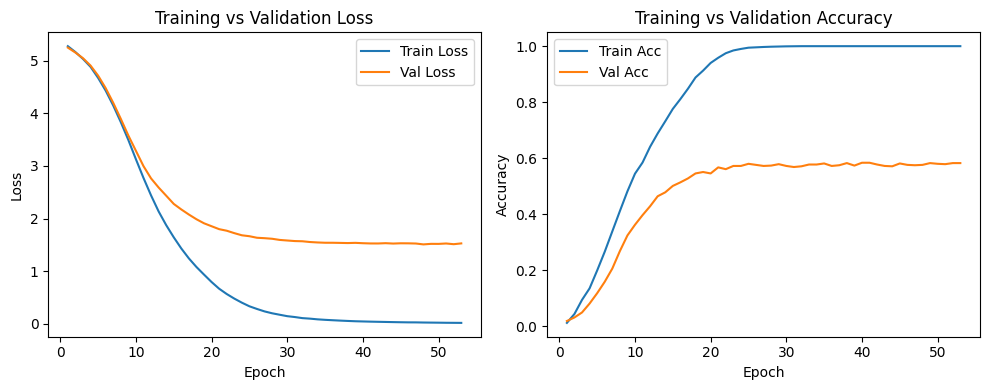

In [24]:
train_val_plot(train_losses, val_losses, train_accs, val_accs)

### Predict labels

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------- Load model -------------------
model = timm.create_model("resnet50.a1_in1k", pretrained=False)

num_features = model.get_classifier().in_features
model.fc = nn.Linear(num_features, 200)

model.load_state_dict(torch.load("best_resnet50_2nd_trial.pt", map_location=device))

model = model.to(device)
model.eval()

test_df = pd.read_csv("data/test_images_path.csv")
test_df["image_path"] = test_df["image_path"].apply(lambda x: os.path.join("data", x.lstrip("/")))

# Dataset and loader
test_dataset = BirdsDataset(test_df, transform=val_transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# ------------------- Predict -------------------
predictions = []

with torch.no_grad():
    for imgs in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())

# Convert 0–199 → 1–200
test_df["label"] = [p + 1 for p in predictions]
test_df = test_df[['id','label']]
test_df.to_csv("resnet_50_2.csv", index=False)
print("Saved submissions!")

Saved submission.csv!


# Introduce attributes information to ResNet 50

In [19]:
# birds_df: (200, 313) with class_id + attributes
attr_tensor = torch.tensor(
    birds_df.drop(columns=["class_id", 'class']).values,
    dtype=torch.float32
).to(device)   # shape: [200, 312]

In [20]:
class ResNetWithAttributes(nn.Module):
    def __init__(self, num_classes=200, emb_dim=512):
        super().__init__()
        
        self.backbone = timm.create_model(
            "resnet50.a1_in1k", pretrained=True, num_classes=0
        )

        self.embed = nn.Linear(self.backbone.num_features, emb_dim)
        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        feat = self.backbone(x)
        emb = self.embed(feat)
        logits = self.classifier(emb)
        return logits, emb

In [21]:
ResNet_model = ResNetWithAttributes(num_classes=200, emb_dim=512).to(device)

In [22]:
attr_proj = nn.Linear(312, 512).to(device)
criterion_cls = nn.CrossEntropyLoss()
criterion_attr = nn.MSELoss()

lambda_attr = 0.2   # weight for attribute alignment

In [23]:
for param in ResNet_model.parameters():
    param.requires_grad = False

for param in ResNet_model.classifier.parameters():
    param.requires_grad = True

for param in ResNet_model.embed.parameters():
    param.requires_grad = True

In [24]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad,
           list(ResNet_model.parameters()) + list(attr_proj.parameters())),
    lr=1e-4,
    weight_decay=1e-4
)

In [25]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        logits, img_emb = model(images)

        # ---- classification loss ----
        loss_cls = criterion_cls(logits, labels)

        # ---- attribute alignment loss ----
        class_attrs = attr_tensor[labels]        # [B, 312]
        attr_emb = attr_proj(class_attrs)        # [B, 512]
        loss_attr = criterion_attr(img_emb, attr_emb)

        loss = loss_cls + lambda_attr * loss_attr
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total


In [26]:
def evaluate(model, loader, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits, _ = model(images)

            loss = criterion_cls(logits, labels)

            total_loss += loss.item()
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total

In [27]:
early_stopping = EarlyStopping(patience=5, min_delta=0.001, verbose=True)
num_epochs = 60
best_val_acc = 0.0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    # UNFREEZE AFTER 3 EPOCHS
    if epoch == 4:
        print("Unfreezing entire ResNet50")
        print('\n')
        for param in ResNet_model.parameters():
            param.requires_grad = True

        # IMPORTANT: include attr_proj parameters
        optimizer = torch.optim.AdamW(
            list(ResNet_model.parameters()) + list(attr_proj.parameters()),
            lr=5e-5,          # safer after unfreezing
            weight_decay=1e-4
        )

    # TRAIN
    train_loss, train_acc = train_one_epoch(
        ResNet_model,
        train_loader,
        optimizer,
        device
    )

    # VALIDATION
    val_loss, val_acc = evaluate(
        ResNet_model,
        val_loader,
        device
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"  Train | loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"  Val   | loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    # EARLY STOPPING (VAL LOSS)
    early_stopping(val_loss, ResNet_model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

    # SAVE BEST MODEL (VAL ACC)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model": ResNet_model.state_dict(),
            "attr_proj": attr_proj.state_dict()
        }, "best_resnet50_attr.pt")

        print(f"✅ New best model saved | val_acc = {best_val_acc:.4f}")



Epoch 1/60


100%|██████████| 25/25 [00:04<00:00,  6.08it/s]


  Train | loss: 5.2794, acc: 0.0150
  Val   | loss: 5.2481, acc: 0.0229
Validation loss decreased (inf → 5.248120). Saving model...
✅ New best model saved | val_acc = 0.0229

Epoch 2/60


100%|██████████| 25/25 [00:03<00:00,  6.99it/s]


  Train | loss: 5.2011, acc: 0.0341
  Val   | loss: 5.1777, acc: 0.0369
Validation loss decreased (5.248120 → 5.177688). Saving model...
✅ New best model saved | val_acc = 0.0369

Epoch 3/60


100%|██████████| 25/25 [00:03<00:00,  6.96it/s]


  Train | loss: 5.1266, acc: 0.0653
  Val   | loss: 5.1167, acc: 0.0802
Validation loss decreased (5.177688 → 5.116675). Saving model...
✅ New best model saved | val_acc = 0.0802

Epoch 4/60
Unfreezing entire ResNet50


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


  Train | loss: 5.0495, acc: 0.0876
  Val   | loss: 5.0387, acc: 0.0789
Validation loss decreased (5.116675 → 5.038713). Saving model...

Epoch 5/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 4.9463, acc: 0.1188
  Val   | loss: 4.9507, acc: 0.1018
Validation loss decreased (5.038713 → 4.950665). Saving model...
✅ New best model saved | val_acc = 0.1018

Epoch 6/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 4.8247, acc: 0.1500
  Val   | loss: 4.8281, acc: 0.1260
Validation loss decreased (4.950665 → 4.828150). Saving model...
✅ New best model saved | val_acc = 0.1260

Epoch 7/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 4.6690, acc: 0.1904
  Val   | loss: 4.6690, acc: 0.1349
Validation loss decreased (4.828150 → 4.669024). Saving model...
✅ New best model saved | val_acc = 0.1349

Epoch 8/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 4.4779, acc: 0.2261
  Val   | loss: 4.4698, acc: 0.1768
Validation loss decreased (4.669024 → 4.469843). Saving model...
✅ New best model saved | val_acc = 0.1768

Epoch 9/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 4.2556, acc: 0.2726
  Val   | loss: 4.2392, acc: 0.2023
Validation loss decreased (4.469843 → 4.239226). Saving model...
✅ New best model saved | val_acc = 0.2023

Epoch 10/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 3.9919, acc: 0.3134
  Val   | loss: 3.9664, acc: 0.2316
Validation loss decreased (4.239226 → 3.966362). Saving model...
✅ New best model saved | val_acc = 0.2316

Epoch 11/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 3.7215, acc: 0.3452
  Val   | loss: 3.6937, acc: 0.2697
Validation loss decreased (3.966362 → 3.693709). Saving model...
✅ New best model saved | val_acc = 0.2697

Epoch 12/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 3.4341, acc: 0.3971
  Val   | loss: 3.4319, acc: 0.3053
Validation loss decreased (3.693709 → 3.431940). Saving model...
✅ New best model saved | val_acc = 0.3053

Epoch 13/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 3.1549, acc: 0.4373
  Val   | loss: 3.1775, acc: 0.3435
Validation loss decreased (3.431940 → 3.177483). Saving model...
✅ New best model saved | val_acc = 0.3435

Epoch 14/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 2.8984, acc: 0.4758
  Val   | loss: 2.9682, acc: 0.3588
Validation loss decreased (3.177483 → 2.968163). Saving model...
✅ New best model saved | val_acc = 0.3588

Epoch 15/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 2.6628, acc: 0.5159
  Val   | loss: 2.7727, acc: 0.3855
Validation loss decreased (2.968163 → 2.772697). Saving model...
✅ New best model saved | val_acc = 0.3855

Epoch 16/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 2.4487, acc: 0.5529
  Val   | loss: 2.6167, acc: 0.4224
Validation loss decreased (2.772697 → 2.616737). Saving model...
✅ New best model saved | val_acc = 0.4224

Epoch 17/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 2.2457, acc: 0.5946
  Val   | loss: 2.4745, acc: 0.4389
Validation loss decreased (2.616737 → 2.474453). Saving model...
✅ New best model saved | val_acc = 0.4389

Epoch 18/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 2.0779, acc: 0.6350
  Val   | loss: 2.3670, acc: 0.4555
Validation loss decreased (2.474453 → 2.366972). Saving model...
✅ New best model saved | val_acc = 0.4555

Epoch 19/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 1.9217, acc: 0.6640
  Val   | loss: 2.2625, acc: 0.4707
Validation loss decreased (2.366972 → 2.262540). Saving model...
✅ New best model saved | val_acc = 0.4707

Epoch 20/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 1.7853, acc: 0.7051
  Val   | loss: 2.1700, acc: 0.4860
Validation loss decreased (2.262540 → 2.170000). Saving model...
✅ New best model saved | val_acc = 0.4860

Epoch 21/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 1.6556, acc: 0.7354
  Val   | loss: 2.0809, acc: 0.5064
Validation loss decreased (2.170000 → 2.080948). Saving model...
✅ New best model saved | val_acc = 0.5064

Epoch 22/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 1.5434, acc: 0.7589
  Val   | loss: 2.0216, acc: 0.5115
Validation loss decreased (2.080948 → 2.021586). Saving model...
✅ New best model saved | val_acc = 0.5115

Epoch 23/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 1.4331, acc: 0.7838
  Val   | loss: 1.9571, acc: 0.5369
Validation loss decreased (2.021586 → 1.957086). Saving model...
✅ New best model saved | val_acc = 0.5369

Epoch 24/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 1.3277, acc: 0.8096
  Val   | loss: 1.9002, acc: 0.5356
Validation loss decreased (1.957086 → 1.900216). Saving model...

Epoch 25/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 1.2356, acc: 0.8411
  Val   | loss: 1.8500, acc: 0.5356
Validation loss decreased (1.900216 → 1.850000). Saving model...

Epoch 26/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 1.1533, acc: 0.8570
  Val   | loss: 1.8206, acc: 0.5407
Validation loss decreased (1.850000 → 1.820582). Saving model...
✅ New best model saved | val_acc = 0.5407

Epoch 27/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 1.0651, acc: 0.8790
  Val   | loss: 1.7776, acc: 0.5483
Validation loss decreased (1.820582 → 1.777557). Saving model...
✅ New best model saved | val_acc = 0.5483

Epoch 28/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 0.9894, acc: 0.9025
  Val   | loss: 1.7446, acc: 0.5560
Validation loss decreased (1.777557 → 1.744634). Saving model...
✅ New best model saved | val_acc = 0.5560

Epoch 29/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 0.9127, acc: 0.9143
  Val   | loss: 1.7135, acc: 0.5585
Validation loss decreased (1.744634 → 1.713499). Saving model...
✅ New best model saved | val_acc = 0.5585

Epoch 30/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 0.8439, acc: 0.9322
  Val   | loss: 1.6989, acc: 0.5674
Validation loss decreased (1.713499 → 1.698884). Saving model...
✅ New best model saved | val_acc = 0.5674

Epoch 31/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 0.7926, acc: 0.9459
  Val   | loss: 1.6775, acc: 0.5725
Validation loss decreased (1.698884 → 1.677539). Saving model...
✅ New best model saved | val_acc = 0.5725

Epoch 32/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 0.7315, acc: 0.9573
  Val   | loss: 1.6568, acc: 0.5725
Validation loss decreased (1.677539 → 1.656789). Saving model...

Epoch 33/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 0.6832, acc: 0.9621
  Val   | loss: 1.6328, acc: 0.5763
Validation loss decreased (1.656789 → 1.632769). Saving model...
✅ New best model saved | val_acc = 0.5763

Epoch 34/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 0.6333, acc: 0.9752
  Val   | loss: 1.6428, acc: 0.5700
EarlyStopping counter: 1/5

Epoch 35/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 0.5947, acc: 0.9787
  Val   | loss: 1.6268, acc: 0.5751
Validation loss decreased (1.632769 → 1.626816). Saving model...

Epoch 36/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 0.5560, acc: 0.9844
  Val   | loss: 1.6102, acc: 0.5814
Validation loss decreased (1.626816 → 1.610211). Saving model...
✅ New best model saved | val_acc = 0.5814

Epoch 37/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 0.5165, acc: 0.9869
  Val   | loss: 1.6025, acc: 0.5802
Validation loss decreased (1.610211 → 1.602531). Saving model...

Epoch 38/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 0.4848, acc: 0.9920
  Val   | loss: 1.5997, acc: 0.5827
Validation loss decreased (1.602531 → 1.599685). Saving model...
✅ New best model saved | val_acc = 0.5827

Epoch 39/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 0.4593, acc: 0.9908
  Val   | loss: 1.6042, acc: 0.5814
EarlyStopping counter: 1/5

Epoch 40/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 0.4295, acc: 0.9962
  Val   | loss: 1.6013, acc: 0.5814
EarlyStopping counter: 2/5

Epoch 41/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 0.4046, acc: 0.9962
  Val   | loss: 1.5905, acc: 0.5802
Validation loss decreased (1.599685 → 1.590486). Saving model...

Epoch 42/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 0.3844, acc: 0.9971
  Val   | loss: 1.5856, acc: 0.5789
Validation loss decreased (1.590486 → 1.585562). Saving model...

Epoch 43/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 0.3673, acc: 0.9978
  Val   | loss: 1.5976, acc: 0.5776
EarlyStopping counter: 1/5

Epoch 44/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 0.3508, acc: 0.9981
  Val   | loss: 1.5921, acc: 0.5814
EarlyStopping counter: 2/5

Epoch 45/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 0.3358, acc: 0.9990
  Val   | loss: 1.5947, acc: 0.5852
EarlyStopping counter: 3/5
✅ New best model saved | val_acc = 0.5852

Epoch 46/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 0.3193, acc: 0.9990
  Val   | loss: 1.6005, acc: 0.5789
EarlyStopping counter: 4/5

Epoch 47/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 0.3064, acc: 0.9990
  Val   | loss: 1.6021, acc: 0.5852
EarlyStopping counter: 5/5
Early stopping triggered!


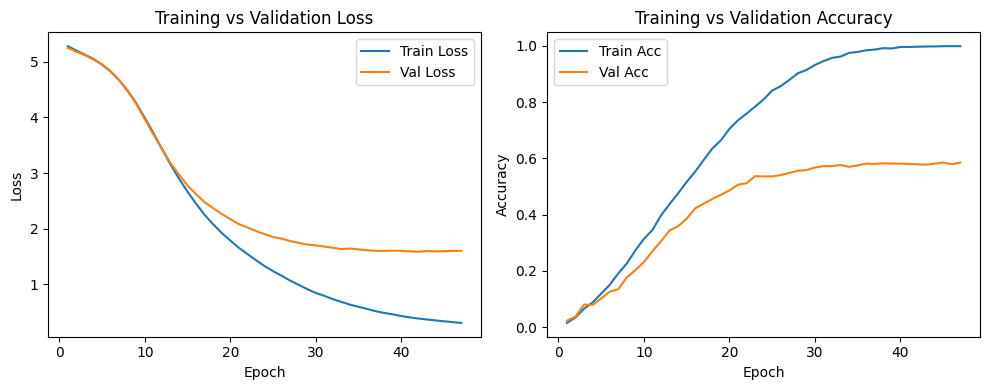

In [28]:
train_val_plot(train_losses, val_losses, train_accs, val_accs)

In [30]:
# ------------------- Load model -------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint = torch.load("best_resnet50_attr.pt", map_location=device)

model = ResNetWithAttributes(num_classes=200, emb_dim=512).to(device)
model.load_state_dict(checkpoint["model"])

model.eval()

test_df = pd.read_csv("data/test_images_path.csv")
test_df["image_path"] = test_df["image_path"].apply(lambda x: os.path.join("data", x.lstrip("/")))

# Dataset and loader
test_dataset = BirdsDataset(test_df, transform=val_transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# ------------------- Predict -------------------
predictions = []
with torch.no_grad():
    for imgs in test_loader:
        imgs = imgs.to(device)
        logits, _ = model(imgs)   #unpack tuple
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())

# Convert 0–199 → 1–200
test_df["label"] = [p + 1 for p in predictions]
test_df = test_df[['id','label']]
test_df.to_csv("resnet_50_2_at.csv", index=False)
print("Saved submissions!")

Saved submissions!


## Bird-species classifier pretrained model
[https://huggingface.co/ozzyonfire/bird-species-classifier]

In [46]:
from transformers import (AutoImageProcessor, AutoModelForImageClassification)
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = AutoImageProcessor.from_pretrained("chriamue/bird-species-classifier")
model = AutoModelForImageClassification.from_pretrained("chriamue/bird-species-classifier", num_labels=200, ignore_mismatched_sizes=True).to(device)

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at chriamue/bird-species-classifier and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([525]) in the checkpoint and torch.Size([200]) in the model instantiated
- classifier.weight: found shape torch.Size([525, 1408]) in the checkpoint and torch.Size([200, 1408]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, 200).to(device)

In [48]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=1e-4, weight_decay=1e-4)

In [47]:
class BirdsDatasetHF(Dataset):
    def __init__(self, df, processor, is_test=False):
        self.df = df
        self.processor = processor
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        image = Image.open(img_path).convert("RGB")

        inputs = self.processor(image, return_tensors="pt")

        pixel_values = inputs["pixel_values"].squeeze(0)

        if self.is_test:
            return pixel_values

        label = self.df.iloc[idx]["label"] - 1
        return pixel_values, label

In [48]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=images)
        logits = outputs.logits

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(pixel_values=images)
            logits = outputs.logits

            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(loader), correct / total

In [52]:
# early_stopping already defined earlier
early_stopping = EarlyStopping(patience=5, min_delta=0.001, verbose=True)
num_epochs = 60
best_val_acc = 0.0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    # Unfreeze network after 3 epochs
    if epoch == 4:
        print("Unfreezing entire EfficientNet / HF model")
        for param in model.parameters():
            param.requires_grad = True

        # When you unfreeze, RECREATE optimizer to include all params
        # Use a smaller lr after unfreezing
        optimizer = torch.optim.AdamW(
            list(model.parameters()),
            lr=3e-5,
            weight_decay=1e-4
        )

    # TRAIN
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    # VALIDATION
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )

    # LOGGING
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # EARLY STOPPING (on validation loss)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

    print(f"  Train | loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"  Val   | loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    # SAVE BEST MODEL (BY VAL ACC)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_acc": best_val_acc
        }, "best_bird_classifier.pt")
        print(f"New best model saved with val_acc = {best_val_acc:.4f}")



Epoch 1/60


100%|██████████| 13/13 [00:00<00:00, 14.92it/s]


Validation loss decreased (inf → 4.893877). Saving model...
  Train | loss: 5.0776, acc: 0.0389
  Val   | loss: 4.8939, acc: 0.0980
New best model saved with val_acc = 0.0980

Epoch 2/60


100%|██████████| 13/13 [00:00<00:00, 14.85it/s]


Validation loss decreased (4.893877 → 4.594168). Saving model...
  Train | loss: 4.3793, acc: 0.2153
  Val   | loss: 4.5942, acc: 0.2036
New best model saved with val_acc = 0.2036

Epoch 3/60


100%|██████████| 13/13 [00:00<00:00, 14.88it/s]


Validation loss decreased (4.594168 → 4.355134). Saving model...
  Train | loss: 3.8074, acc: 0.3739
  Val   | loss: 4.3551, acc: 0.2926
New best model saved with val_acc = 0.2926

Epoch 4/60
Unfreezing entire EfficientNet / HF model


100%|██████████| 13/13 [00:00<00:00, 14.61it/s]


Validation loss decreased (4.355134 → 4.068440). Saving model...
  Train | loss: 3.3076, acc: 0.4717
  Val   | loss: 4.0684, acc: 0.3333
New best model saved with val_acc = 0.3333

Epoch 5/60


100%|██████████| 13/13 [00:00<00:00, 14.89it/s]


EarlyStopping counter: 1/5
  Train | loss: 2.8425, acc: 0.5439
  Val   | loss: 5.0985, acc: 0.4466
New best model saved with val_acc = 0.4466

Epoch 6/60


100%|██████████| 13/13 [00:00<00:00, 14.85it/s]


Validation loss decreased (4.068440 → 3.474242). Saving model...
  Train | loss: 2.5131, acc: 0.5917
  Val   | loss: 3.4742, acc: 0.4237

Epoch 7/60


100%|██████████| 13/13 [00:00<00:00, 14.70it/s]


Validation loss decreased (3.474242 → 2.948560). Saving model...
  Train | loss: 2.2310, acc: 0.6433
  Val   | loss: 2.9486, acc: 0.4733
New best model saved with val_acc = 0.4733

Epoch 8/60


100%|██████████| 13/13 [00:00<00:00, 14.67it/s]


EarlyStopping counter: 1/5
  Train | loss: 1.9891, acc: 0.6752
  Val   | loss: 3.0009, acc: 0.4046

Epoch 9/60


100%|██████████| 13/13 [00:00<00:00, 14.55it/s]


Validation loss decreased (2.948560 → 2.604794). Saving model...
  Train | loss: 1.7992, acc: 0.7096
  Val   | loss: 2.6048, acc: 0.5038
New best model saved with val_acc = 0.5038

Epoch 10/60


100%|██████████| 13/13 [00:00<00:00, 14.47it/s]


EarlyStopping counter: 1/5
  Train | loss: 1.6279, acc: 0.7471
  Val   | loss: 2.6080, acc: 0.5394
New best model saved with val_acc = 0.5394

Epoch 11/60


100%|██████████| 13/13 [00:00<00:00, 14.93it/s]


Validation loss decreased (2.604794 → 2.588290). Saving model...
  Train | loss: 1.4858, acc: 0.7774
  Val   | loss: 2.5883, acc: 0.5305

Epoch 12/60


100%|██████████| 13/13 [00:00<00:00, 15.00it/s]


EarlyStopping counter: 1/5
  Train | loss: 1.3586, acc: 0.8029
  Val   | loss: 2.5946, acc: 0.5229

Epoch 13/60


100%|██████████| 13/13 [00:00<00:00, 14.75it/s]


EarlyStopping counter: 2/5
  Train | loss: 1.2122, acc: 0.8344
  Val   | loss: 10.3233, acc: 0.5458
New best model saved with val_acc = 0.5458

Epoch 14/60


100%|██████████| 13/13 [00:00<00:00, 14.42it/s]


Validation loss decreased (2.588290 → 2.205286). Saving model...
  Train | loss: 1.1282, acc: 0.8583
  Val   | loss: 2.2053, acc: 0.5471
New best model saved with val_acc = 0.5471

Epoch 15/60


100%|██████████| 13/13 [00:00<00:00, 14.86it/s]


EarlyStopping counter: 1/5
  Train | loss: 1.0168, acc: 0.8694
  Val   | loss: 2.4598, acc: 0.5013

Epoch 16/60


100%|██████████| 13/13 [00:00<00:00, 14.62it/s]


EarlyStopping counter: 2/5
  Train | loss: 0.9160, acc: 0.8939
  Val   | loss: 2.3585, acc: 0.5178

Epoch 17/60


100%|██████████| 13/13 [00:00<00:00, 14.80it/s]


Validation loss decreased (2.205286 → 2.144846). Saving model...
  Train | loss: 0.8257, acc: 0.9146
  Val   | loss: 2.1448, acc: 0.5623
New best model saved with val_acc = 0.5623

Epoch 18/60


100%|██████████| 13/13 [00:00<00:00, 14.78it/s]


EarlyStopping counter: 1/5
  Train | loss: 0.7625, acc: 0.9264
  Val   | loss: 2.3087, acc: 0.5165

Epoch 19/60


100%|██████████| 13/13 [00:00<00:00, 14.51it/s]


Validation loss decreased (2.144846 → 2.018124). Saving model...
  Train | loss: 0.6831, acc: 0.9347
  Val   | loss: 2.0181, acc: 0.5980
New best model saved with val_acc = 0.5980

Epoch 20/60


100%|██████████| 13/13 [00:00<00:00, 14.62it/s]


Validation loss decreased (2.018124 → 1.967162). Saving model...
  Train | loss: 0.6060, acc: 0.9459
  Val   | loss: 1.9672, acc: 0.5814

Epoch 21/60


100%|██████████| 13/13 [00:00<00:00, 14.92it/s]


EarlyStopping counter: 1/5
  Train | loss: 0.5634, acc: 0.9580
  Val   | loss: 2.1821, acc: 0.5305

Epoch 22/60


100%|██████████| 13/13 [00:00<00:00, 14.86it/s]


Validation loss decreased (1.967162 → 1.907258). Saving model...
  Train | loss: 0.4921, acc: 0.9659
  Val   | loss: 1.9073, acc: 0.5840

Epoch 23/60


100%|██████████| 13/13 [00:00<00:00, 14.93it/s]


EarlyStopping counter: 1/5
  Train | loss: 0.5013, acc: 0.9697
  Val   | loss: 2.1226, acc: 0.5293

Epoch 24/60


100%|██████████| 13/13 [00:00<00:00, 14.87it/s]


EarlyStopping counter: 2/5
  Train | loss: 0.4035, acc: 0.9793
  Val   | loss: 1.9797, acc: 0.5827

Epoch 25/60


100%|██████████| 13/13 [00:00<00:00, 14.57it/s]


EarlyStopping counter: 3/5
  Train | loss: 0.3986, acc: 0.9822
  Val   | loss: 2.1350, acc: 0.5598

Epoch 26/60


100%|██████████| 13/13 [00:00<00:00, 14.85it/s]


EarlyStopping counter: 4/5
  Train | loss: 0.3633, acc: 0.9838
  Val   | loss: 2.0973, acc: 0.5534

Epoch 27/60


100%|██████████| 13/13 [00:00<00:00, 14.54it/s]


Validation loss decreased (1.907258 → 1.747337). Saving model...
  Train | loss: 0.3355, acc: 0.9866
  Val   | loss: 1.7473, acc: 0.5967

Epoch 28/60


100%|██████████| 13/13 [00:00<00:00, 14.78it/s]


EarlyStopping counter: 1/5
  Train | loss: 0.2985, acc: 0.9892
  Val   | loss: 1.9333, acc: 0.5891

Epoch 29/60


100%|██████████| 13/13 [00:00<00:00, 14.52it/s]


EarlyStopping counter: 2/5
  Train | loss: 0.2747, acc: 0.9908
  Val   | loss: 1.8258, acc: 0.6527
New best model saved with val_acc = 0.6527

Epoch 30/60


100%|██████████| 13/13 [00:00<00:00, 14.77it/s]


EarlyStopping counter: 3/5
  Train | loss: 0.2486, acc: 0.9936
  Val   | loss: 2.8885, acc: 0.6145

Epoch 31/60


100%|██████████| 13/13 [00:00<00:00, 14.82it/s]


EarlyStopping counter: 4/5
  Train | loss: 0.2417, acc: 0.9946
  Val   | loss: 245.2552, acc: 0.5827

Epoch 32/60


100%|██████████| 13/13 [00:00<00:00, 14.97it/s]

EarlyStopping counter: 5/5
Early stopping triggered!


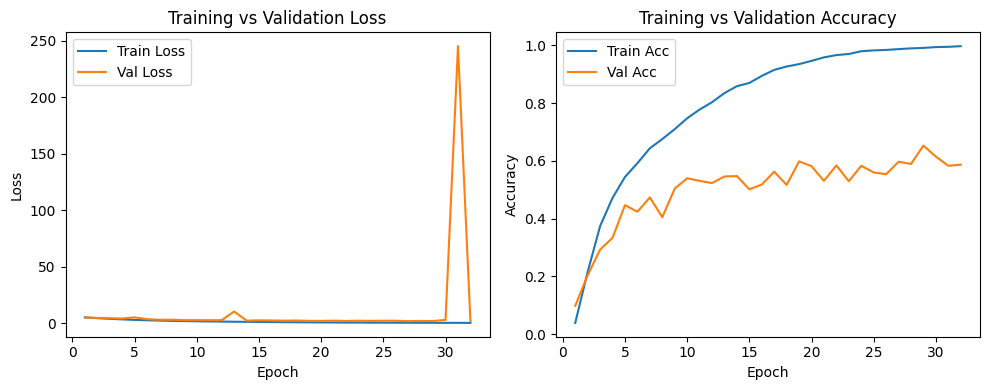

In [57]:
train_val_plot(train_losses, val_losses, train_accs, val_accs)

### Predict labels

In [58]:
test_dataset = BirdsDatasetHF(df=test_df, processor=processor, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_df = pd.read_csv("data/test_images_path.csv")
test_df["image_path"] = test_df["image_path"].apply(lambda x: os.path.join("data", x.lstrip("/")))

# ---- Create dataset + loader ----
test_dataset = BirdsDatasetHF(test_df, processor, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ---- Load best model checkpoint ----
checkpoint = torch.load("best_bird_classifier.pt", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

all_preds = []

with torch.no_grad():
    for pixel_values in test_loader:
        pixel_values = pixel_values.to(device)

        outputs = model(pixel_values)

        # EfficientNet from HF usually returns a ModelOutput with .logits
        logits = outputs.logits if hasattr(outputs, "logits") else outputs
        preds = torch.argmax(logits, dim=1)

        # remember training used (label - 1)
        preds = preds.cpu().numpy() + 1  

        all_preds.extend(preds)

# ---- Save predictions ----
test_df["label"] = all_preds
test_df[['id','label']].to_csv("bird_classifier2.csv", index=False)

print("Saved predictions to bird_classifier1.csv 👍")

Saved predictions to bird_classifier1.csv 👍
